* This notebook was made to look at the salinity / U, V velocity vertical profiles with reduced viscosity, new bathymetry 6, nowcasts, no_banks at Sandheads, VENUS central/east/delta and station S4-3 during ebb and flood tide respectively.

In [1]:
from __future__ import division
from salishsea_tools import (
    nc_tools,
    viz_tools,
    tidetools,
)
from salishsea_tools.nowcast import figures
import scipy.io as sio
import datetime
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import seaborn as sns

In [2]:
%matplotlib inline
sns.set_style('darkgrid')

In [3]:
sites = {
    'Sandheads': {
        'lat': 49.10,
        'lon': -123.30,
        'i' : 426,
        'j' : 293
   
    },
    'VENUS East':{
        'lat' : 49.0419,
        'lon' : -123.3176,
        'depth' : 170,
        'i' : 416,
        'j' : 283
    },    
    'VENUS Central': {
        'lat': 49.0401,
        'lon': -123.4261,
        'depth' : 300,
        'i': 424,
        'j': 266
        },

    'VENUS Delta': {
        'lat': 49.0807167,
        'lon': -123.3400617,
        'i':  425,
        'j':284
    },
    'S4-3':{
        'lat': 49.25 ,
        'lon':  -123.375,
        'i':461,
        'j': 300
        
    },

        }
# Font format
title_font = {
    'fontname': 'Bitstream Vera Sans', 'size': '18', 'color': 'black',
    'weight': 'medium'
}
axis_font = {'fontname': 'Bitstream Vera Sans', 'size': '16'}

In [4]:
## nowcasts 
grid_T = nc.Dataset('/data/dlatorne/MEOPAR/SalishSea/nowcast/early-days/4-10oct14/\
SalishSea_1h_20141004_20141010_grid_T.nc')
grid_U = nc.Dataset('/data/dlatorne/MEOPAR/SalishSea/nowcast/early-days/4-10oct14/\
SalishSea_1h_20141004_20141010_grid_U.nc')
grid_V = nc.Dataset('/data/dlatorne/MEOPAR/SalishSea/nowcast/early-days/4-10oct14/\
SalishSea_1h_20141004_20141010_grid_V.nc')

## new bathymetry 6 default one
grid_TT = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/oct8_10RFdailySmoo/\
SalishSea_1h_20141008_20141010_grid_T.nc')
grid_UU = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/oct8_10RFdailySmoo/\
SalishSea_1h_20141008_20141010_grid_U.nc')
grid_VV = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/oct8_10RFdailySmoo/\
SalishSea_1h_20141008_20141010_grid_V.nc')

## reduced viscosity one
grid_T_redu = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/oct8_10reduceviscosity/\
SalishSea_1h_20141008_20141010_grid_T.nc')
grid_U_redu = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/oct8_10reduceviscosity/\
SalishSea_1h_20141008_20141010_grid_U.nc')
grid_V_redu = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/oct8_10reduceviscosity/\
SalishSea_1h_20141008_20141010_grid_V.nc')

## no banks one
grid_T_noban = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/oct8_10nobanks/\
SalishSea_1h_20141008_20141010_grid_T.nc')
grid_U_noban = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/oct8_10nobanks/\
SalishSea_1h_20141008_20141010_grid_U.nc')
grid_V_noban = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/oct8_10nobanks/\
SalishSea_1h_20141008_20141010_grid_V.nc')

In [5]:
def plot_salinity_UV_SSH(station_name,start_t,duration):
    """This function was made to plot vertical profiles of 
        salinity and magnitude of U&V velocity hourly"""
    salinity1 = grid_T.variables['vosaline']
    salinity2 = grid_TT.variables['vosaline']
    salinity3 = grid_T_redu.variables['vosaline']
    salinity4 = grid_T_noban.variables['vosaline']
    
    ssh = grid_TT.variables['sossheig']
    dd= []
    for d in np.arange(40):
        if salinity1[0,d,sites[station_name]['i'],sites[station_name]['j']] ==0:
            dd.append(d)
    index_d = min(dd)
    
    u1 = grid_U.variables['vozocrtx']
    v1= grid_V.variables['vomecrty']
    u2 = grid_UU.variables['vozocrtx']
    v2= grid_VV.variables['vomecrty']
    u3 = grid_U_redu.variables['vozocrtx']
    v3= grid_V_redu.variables['vomecrty']
    u4 = grid_U_noban.variables['vozocrtx']
    v4= grid_V_noban.variables['vomecrty']
    
    depth = grid_TT.variables['deptht'][:]
    time=np.array([])
    time_ssh=np.array([])
    t = nc_tools.timestamp(grid_TT, np.arange(duration+ start_t))
    t_ssh = nc_tools.timestamp(grid_TT,np.arange(72)) ## Oct 8-10 
    for ind in range(len(t)):
        t[ind] = t[ind].datetime
    time = np.append(time, t[start_t:start_t+duration+1]) 
    for ind in range(len(t_ssh)):
        t_ssh[ind] = t_ssh[ind].datetime
    time_ssh = np.append(time_ssh,t_ssh) 
    
    d_label= []
    for i in depth[:index_d]:
        d_label.append(str(i))##want to turn depth from negative to positive but failed!
    
    if station_name == 'Sandheads':
        fig, axs =plt.subplots(duration,4, figsize = (30,48))
    else:
        fig, axs =plt.subplots(duration,6, figsize = (40,50))
    for tt in range(duration):
        ## for ssh
        ax = axs[tt, 0]
        ax.plot(time_ssh,ssh[:, sites[station_name]['i'],\
                         sites[station_name]['j']], \
                linewidth = 2.5)
        ax.plot(time_ssh[start_t+tt], ssh[start_t + tt, sites[station_name]['i'],\
                         sites[station_name]['j']], color = 'tomato',marker='*', markersize = 18)
       
        ax.set_title(time[tt].strftime('%d-%b-%Y %H:%M') + ' at '+ station_name, **title_font)
        ax.set_xlabel('time', **axis_font)
        ax.set_ylabel('Sea surface height[m]', **axis_font)
        plt.setp(ax.get_xticklabels(), fontsize=18)
        plt.setp(ax.get_yticklabels(), fontsize=18)
    
    for tt in range(duration):
        ## for salinity
        ax = axs[tt, 1]
        ax.plot(salinity1[start_t + tt + 96, 0:index_d, sites[station_name]['i'],\
                         sites[station_name]['j']], -depth[0:index_d], \
                linewidth = 2.5, label = 'nowcast')
        ax.plot(salinity2[start_t + tt, 0:index_d, sites[station_name]['i'],\
                         sites[station_name]['j']], -depth[0:index_d],\
                linewidth = 2.5,label = 'new')
        ax.plot(salinity3[start_t + tt, 0:index_d, sites[station_name]['i'],\
                         sites[station_name]['j']], -depth[0:index_d],\
                linewidth = 2.5,label = 'reduce_viscosity')
        ax.plot(salinity4[start_t + tt, 0:index_d, sites[station_name]['i'],\
                        sites[station_name]['j']], -depth[0:index_d],\
                linewidth = 2.5,label = 'no_banks')
        ax.set_title(time[tt].strftime('%d-%b-%Y %H:%M') + ' at '+ station_name, **title_font)
        ax.set_xlim([10,34])
        ax.set_xlabel('Pratical Salinity', **axis_font)
        ax.set_ylabel('Depth[m]', **axis_font)
        ax.legend(fontsize = 18,loc = 3)
        plt.setp(ax.get_xticklabels(), fontsize=18)
        plt.setp(ax.get_yticklabels(), fontsize=18)
        ## for U velocity
        ax = axs[tt, 2]
        ax.plot(u1[start_t + tt + 96, 0:index_d, sites[station_name]['i'],\
                         sites[station_name]['j']], -depth[0:index_d],\
                linewidth = 2.5,label = 'nowcast')
        ax.plot(u2[start_t + tt, 0:index_d, sites[station_name]['i'],\
                         sites[station_name]['j']], -depth[0:index_d],\
                linewidth = 2.5,label = 'new')
        ax.plot(u3[start_t + tt, 0:index_d, sites[station_name]['i'],\
                         sites[station_name]['j']], -depth[0:index_d],\
                linewidth = 2.5,label = 'reduce_viscosity')
        ax.plot(u4[start_t + tt, 0:index_d, sites[station_name]['i'],\
                         sites[station_name]['j']], -depth[0:index_d],\
                linewidth = 2.5,label = 'no_banks')
        ax.set_title(time[tt].strftime('%d-%b-%Y %H:%M') + ' at '+ station_name, **title_font)
        ax.set_xlim([-0.8,0.8])
        ax.set_xlabel('U velocity[m/s]', **axis_font)
        ax.set_ylabel('Depth[m]', **axis_font)
        ax.legend(fontsize = 18,loc = 3)
        plt.setp(ax.get_xticklabels(), fontsize=18)
        plt.setp(ax.get_yticklabels(), fontsize=18)
        
        ## for V velocity
        ax = axs[tt, 3]
        ax.plot(v1[start_t + tt+ 96, 0:index_d, sites[station_name]['i'],\
                         sites[station_name]['j']], -depth[0:index_d],\
                linewidth = 2.5,label = 'nowcast')
        ax.plot(v2[start_t + tt, 0:index_d, sites[station_name]['i'],\
                         sites[station_name]['j']], -depth[0:index_d],\
                linewidth = 2.5,label = 'new')
        ax.plot(v3[start_t + tt, 0:index_d, sites[station_name]['i'],\
                         sites[station_name]['j']], -depth[0:index_d],\
                linewidth = 2.5,label = 'reduce_viscosity')
        ax.plot(v4[start_t + tt, 0:index_d, sites[station_name]['i'],\
                         sites[station_name]['j']], -depth[0:index_d],\
                linewidth = 2.5,label = 'no_banks')
        ax.set_title(time[tt].strftime('%d-%b-%Y %H:%M') + ' at '+ station_name, **title_font)
        ax.set_xlim([-0.8,0.8])
        ax.set_xlabel('V velocity[m/s]', **axis_font)
        ax.set_ylabel('Depth[m]', **axis_font)
        ax.legend(fontsize = 18, loc = 3)
        plt.setp(ax.get_xticklabels(), fontsize=18)
        plt.setp(ax.get_yticklabels(), fontsize=18)     
        ##zoom in U,V velocity
        if station_name != 'Sandheads':
            ax = axs[tt,4]
            ax.plot(u1[start_t + tt + 96, 0:24, sites[station_name]['i'],\
                         sites[station_name]['j']], -depth[0:24],\
                linewidth = 2.5,label = 'nowcast')
            ax.plot(u2[start_t + tt,  0:24, sites[station_name]['i'],\
                         sites[station_name]['j']], -depth[0:24],\
                linewidth = 2.5,label = 'new')
            ax.plot(u3[start_t + tt,  0:24, sites[station_name]['i'],\
                         sites[station_name]['j']], -depth[0:24],\
                linewidth = 2.5,label = 'reduce_viscosity')
            ax.plot(u4[start_t + tt,  0:24, sites[station_name]['i'],\
                         sites[station_name]['j']], -depth[0:24],\
                linewidth = 2.5,label = 'no_banks')
            ax.set_title(time[tt].strftime('%d-%b-%Y %H:%M') + ' at '+ station_name, **title_font)
            ax.set_xlim([-0.8,0.8])
            ax.set_xlabel('U velocity[m/s]', **axis_font)
            ax.set_ylabel('Depth[m]', **axis_font)
            ax.legend(fontsize = 18,loc = 3)
            plt.setp(ax.get_xticklabels(), fontsize=18)
            plt.setp(ax.get_yticklabels(), fontsize=18)
            
            ax = axs[tt,5]
            ax.plot(v1[start_t + tt + 96, 0:24, sites[station_name]['i'],\
                         sites[station_name]['j']], -depth[0:24],\
                linewidth = 2.5,label = 'nowcast')
            ax.plot(v2[start_t + tt,  0:24, sites[station_name]['i'],\
                         sites[station_name]['j']], -depth[0:24],\
                linewidth = 2.5,label = 'new')
            ax.plot(v3[start_t + tt,  0:24, sites[station_name]['i'],\
                         sites[station_name]['j']], -depth[0:24],\
                linewidth = 2.5,label = 'reduce_viscosity')
            ax.plot(v4[start_t + tt,  0:24, sites[station_name]['i'],\
                         sites[station_name]['j']], -depth[0:24],\
                linewidth = 2.5,label = 'no_banks')
            ax.set_title(time[tt].strftime('%d-%b-%Y %H:%M') + ' at '+ station_name, **title_font)
            ax.set_xlim([-0.8,0.8])
            ax.set_xlabel('V velocity[m/s]', **axis_font)
            ax.set_ylabel('Depth[m]', **axis_font)
            ax.legend(fontsize = 18,loc = 3)
            plt.setp(ax.get_xticklabels(), fontsize=18)
            plt.setp(ax.get_yticklabels(), fontsize=18)
            
    return fig

* Sandheads

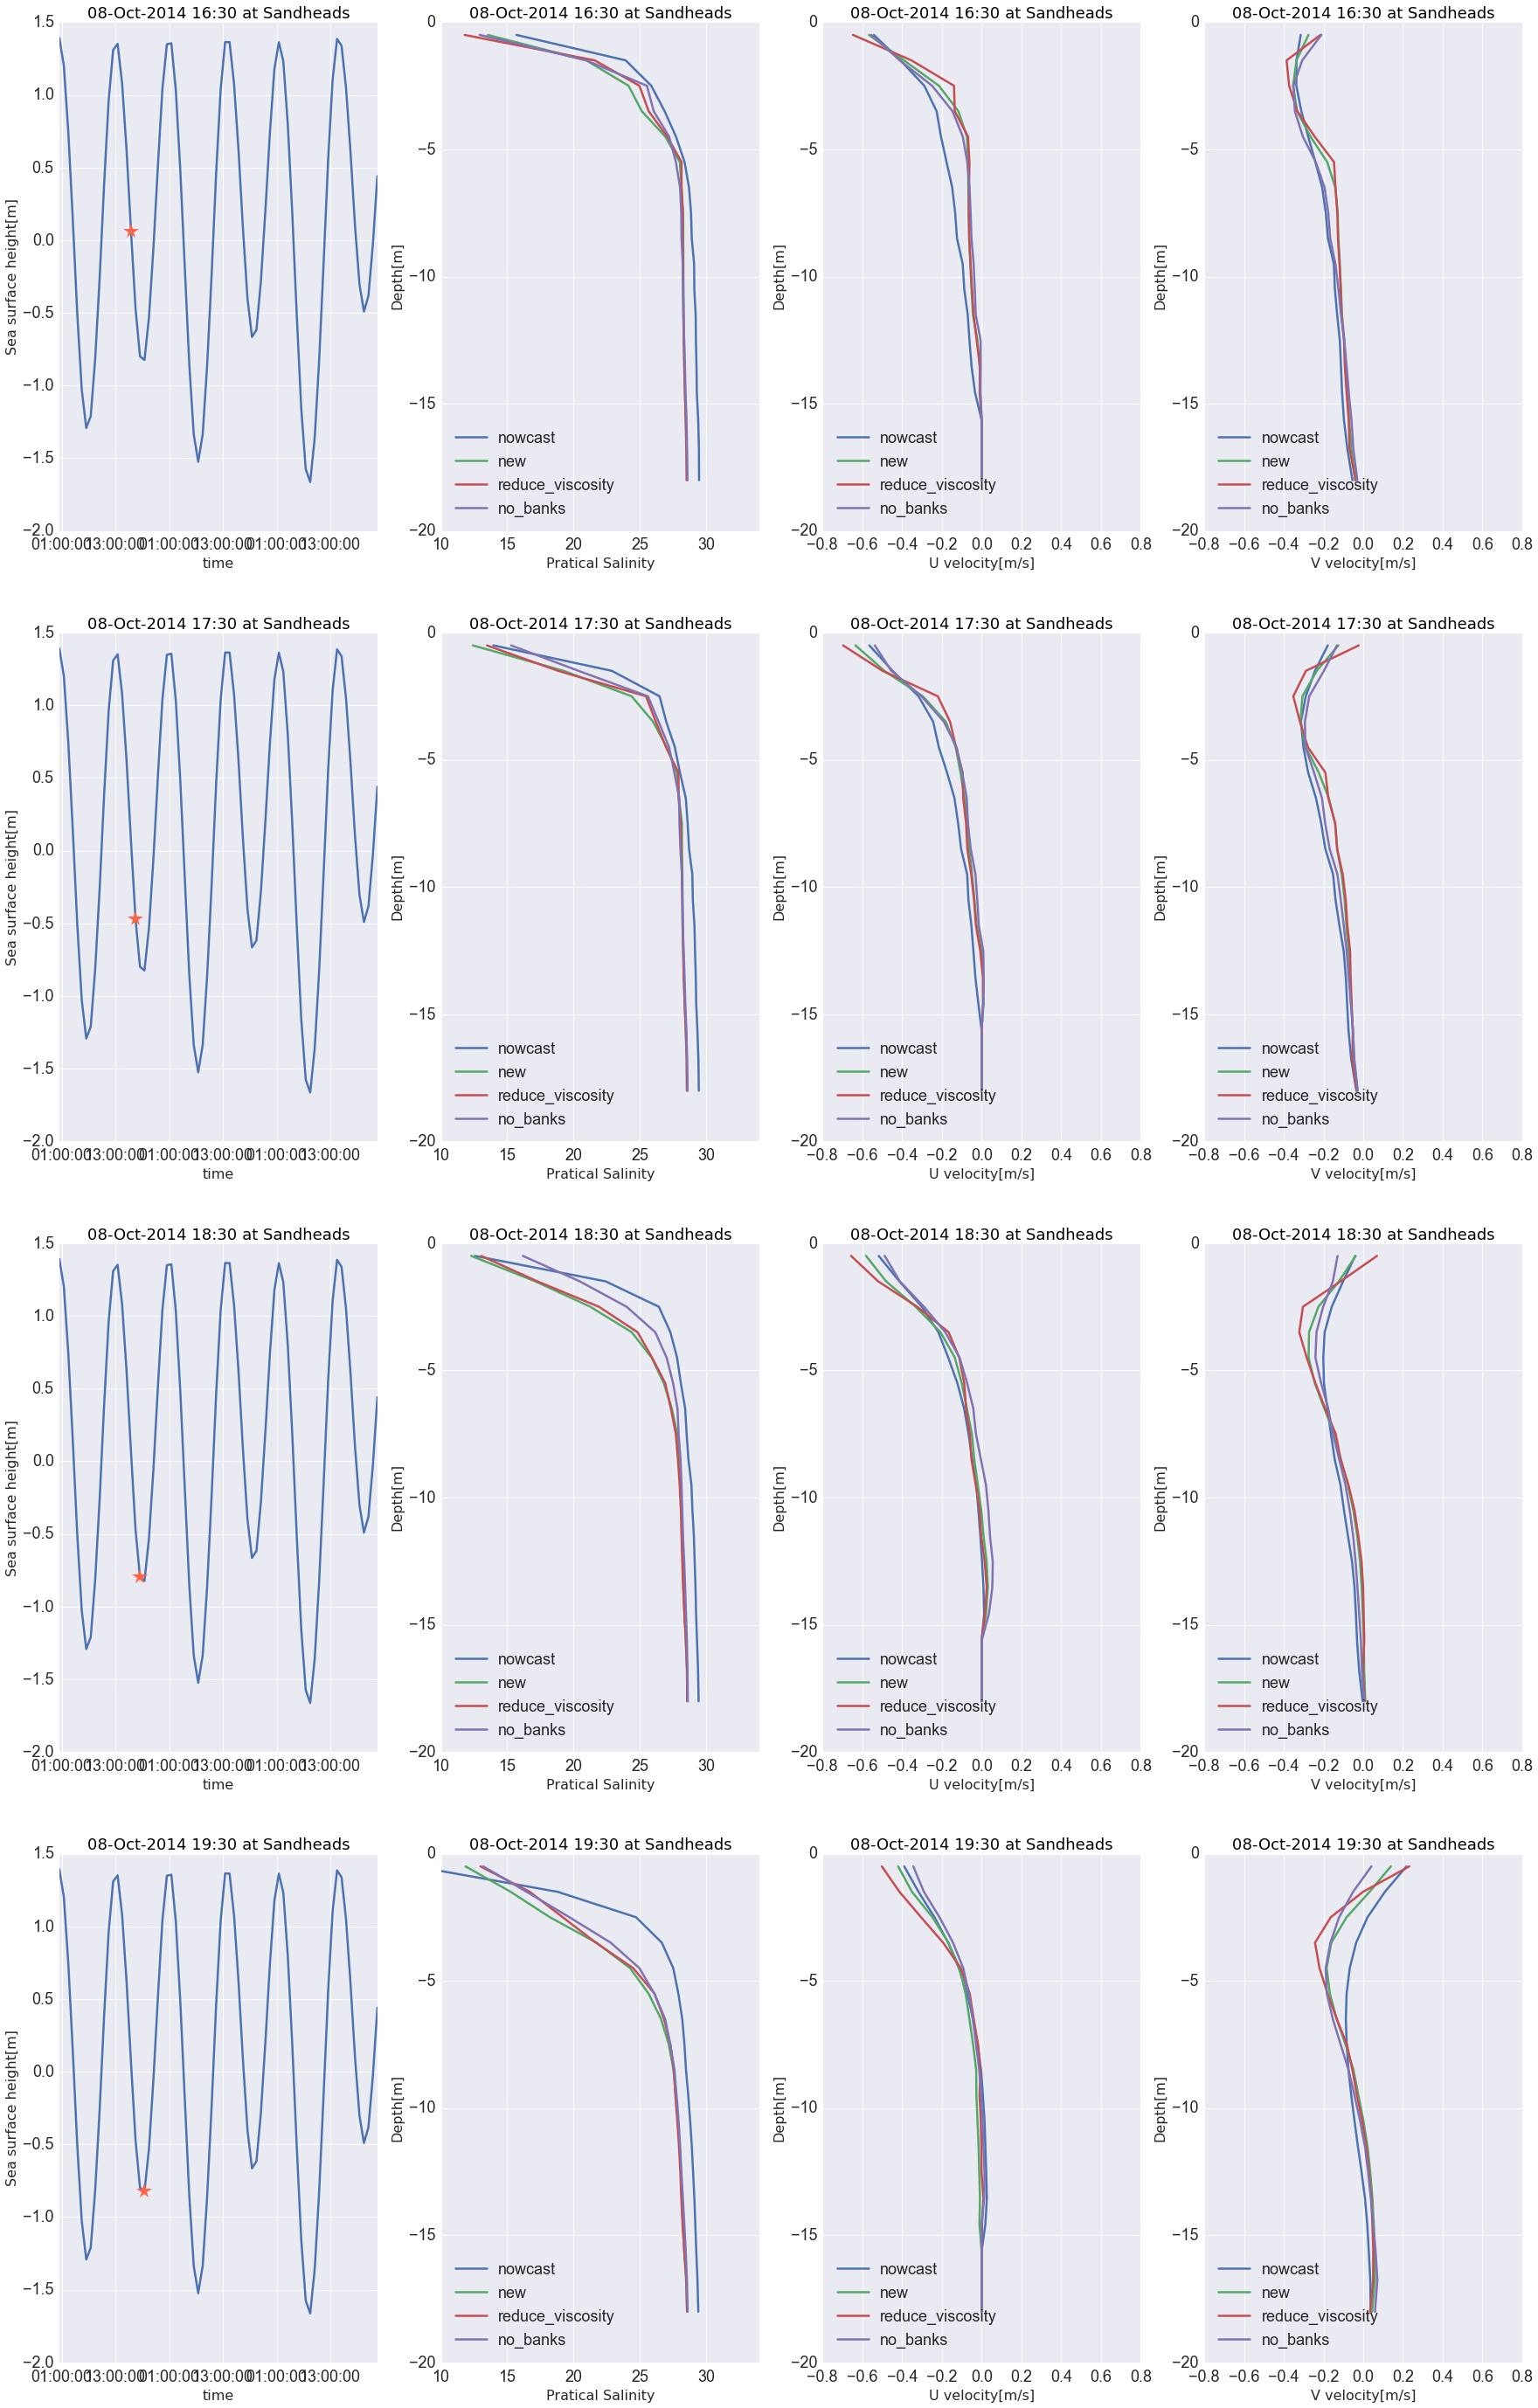

In [6]:
fig = plot_salinity_UV_SSH('Sandheads', 16,4)

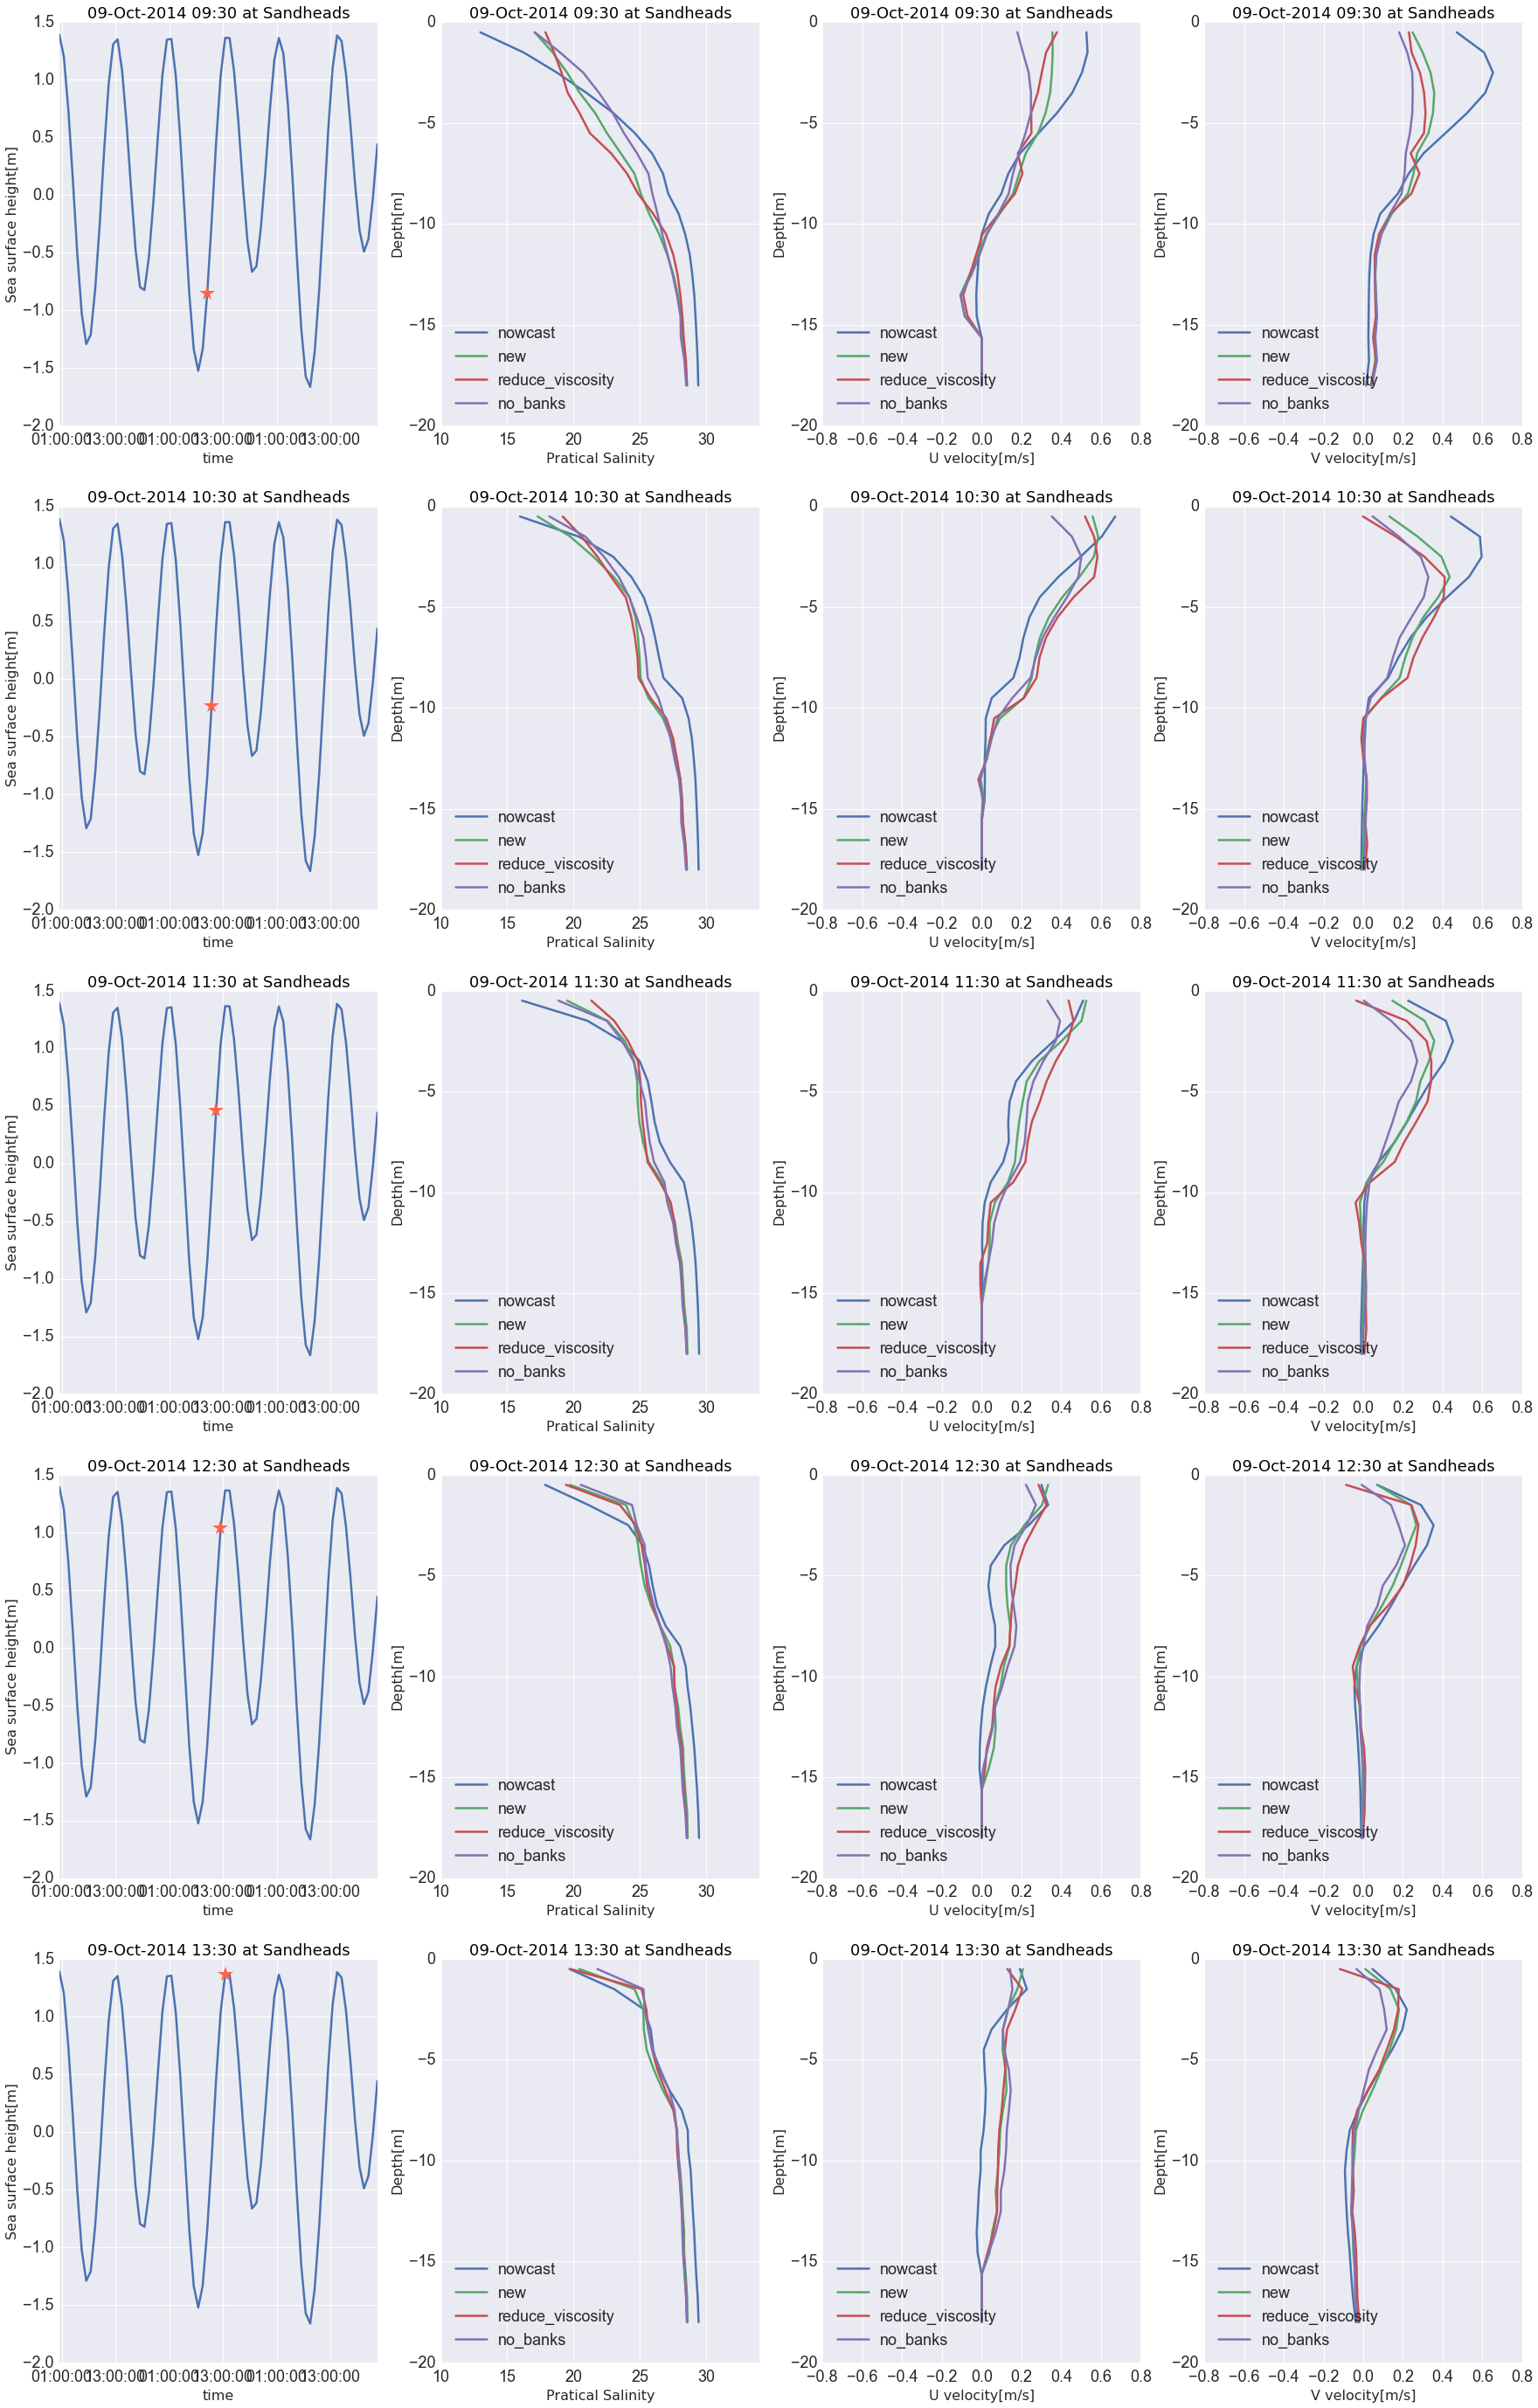

In [7]:
fig = plot_salinity_UV_SSH('Sandheads',33,5)

* VENUS Central

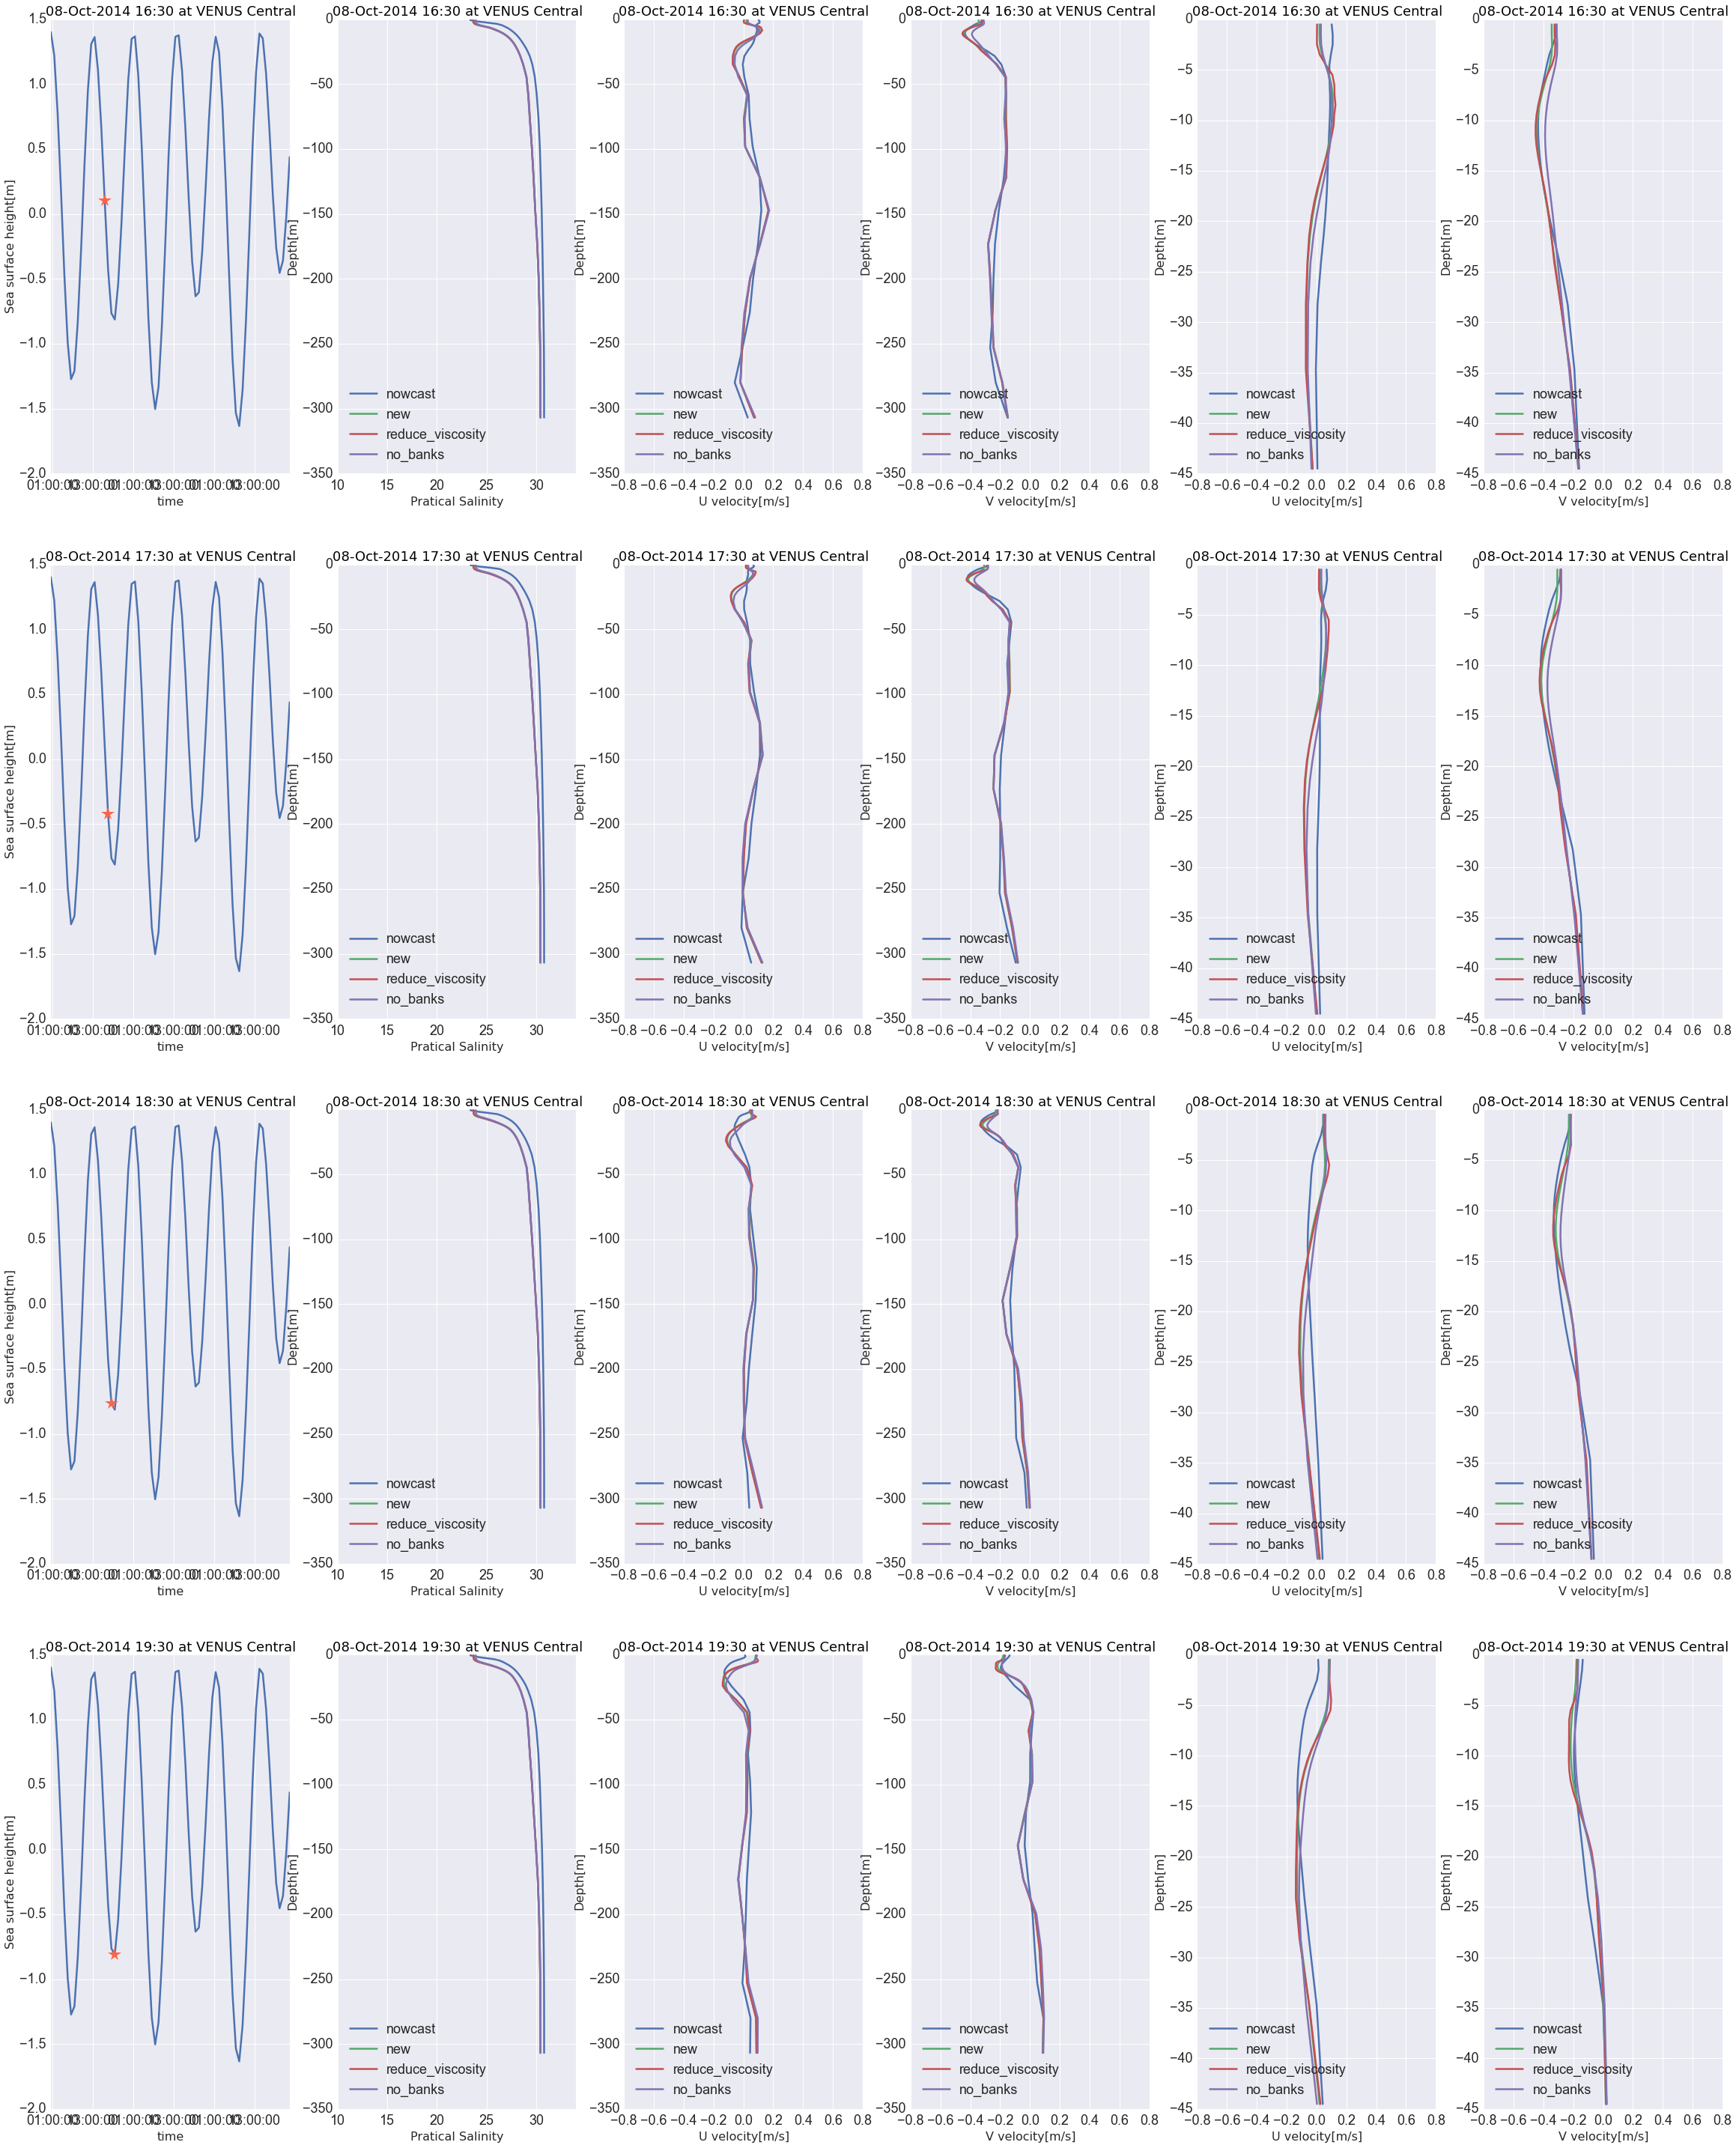

In [8]:
fig = plot_salinity_UV_SSH('VENUS Central', 16,4)

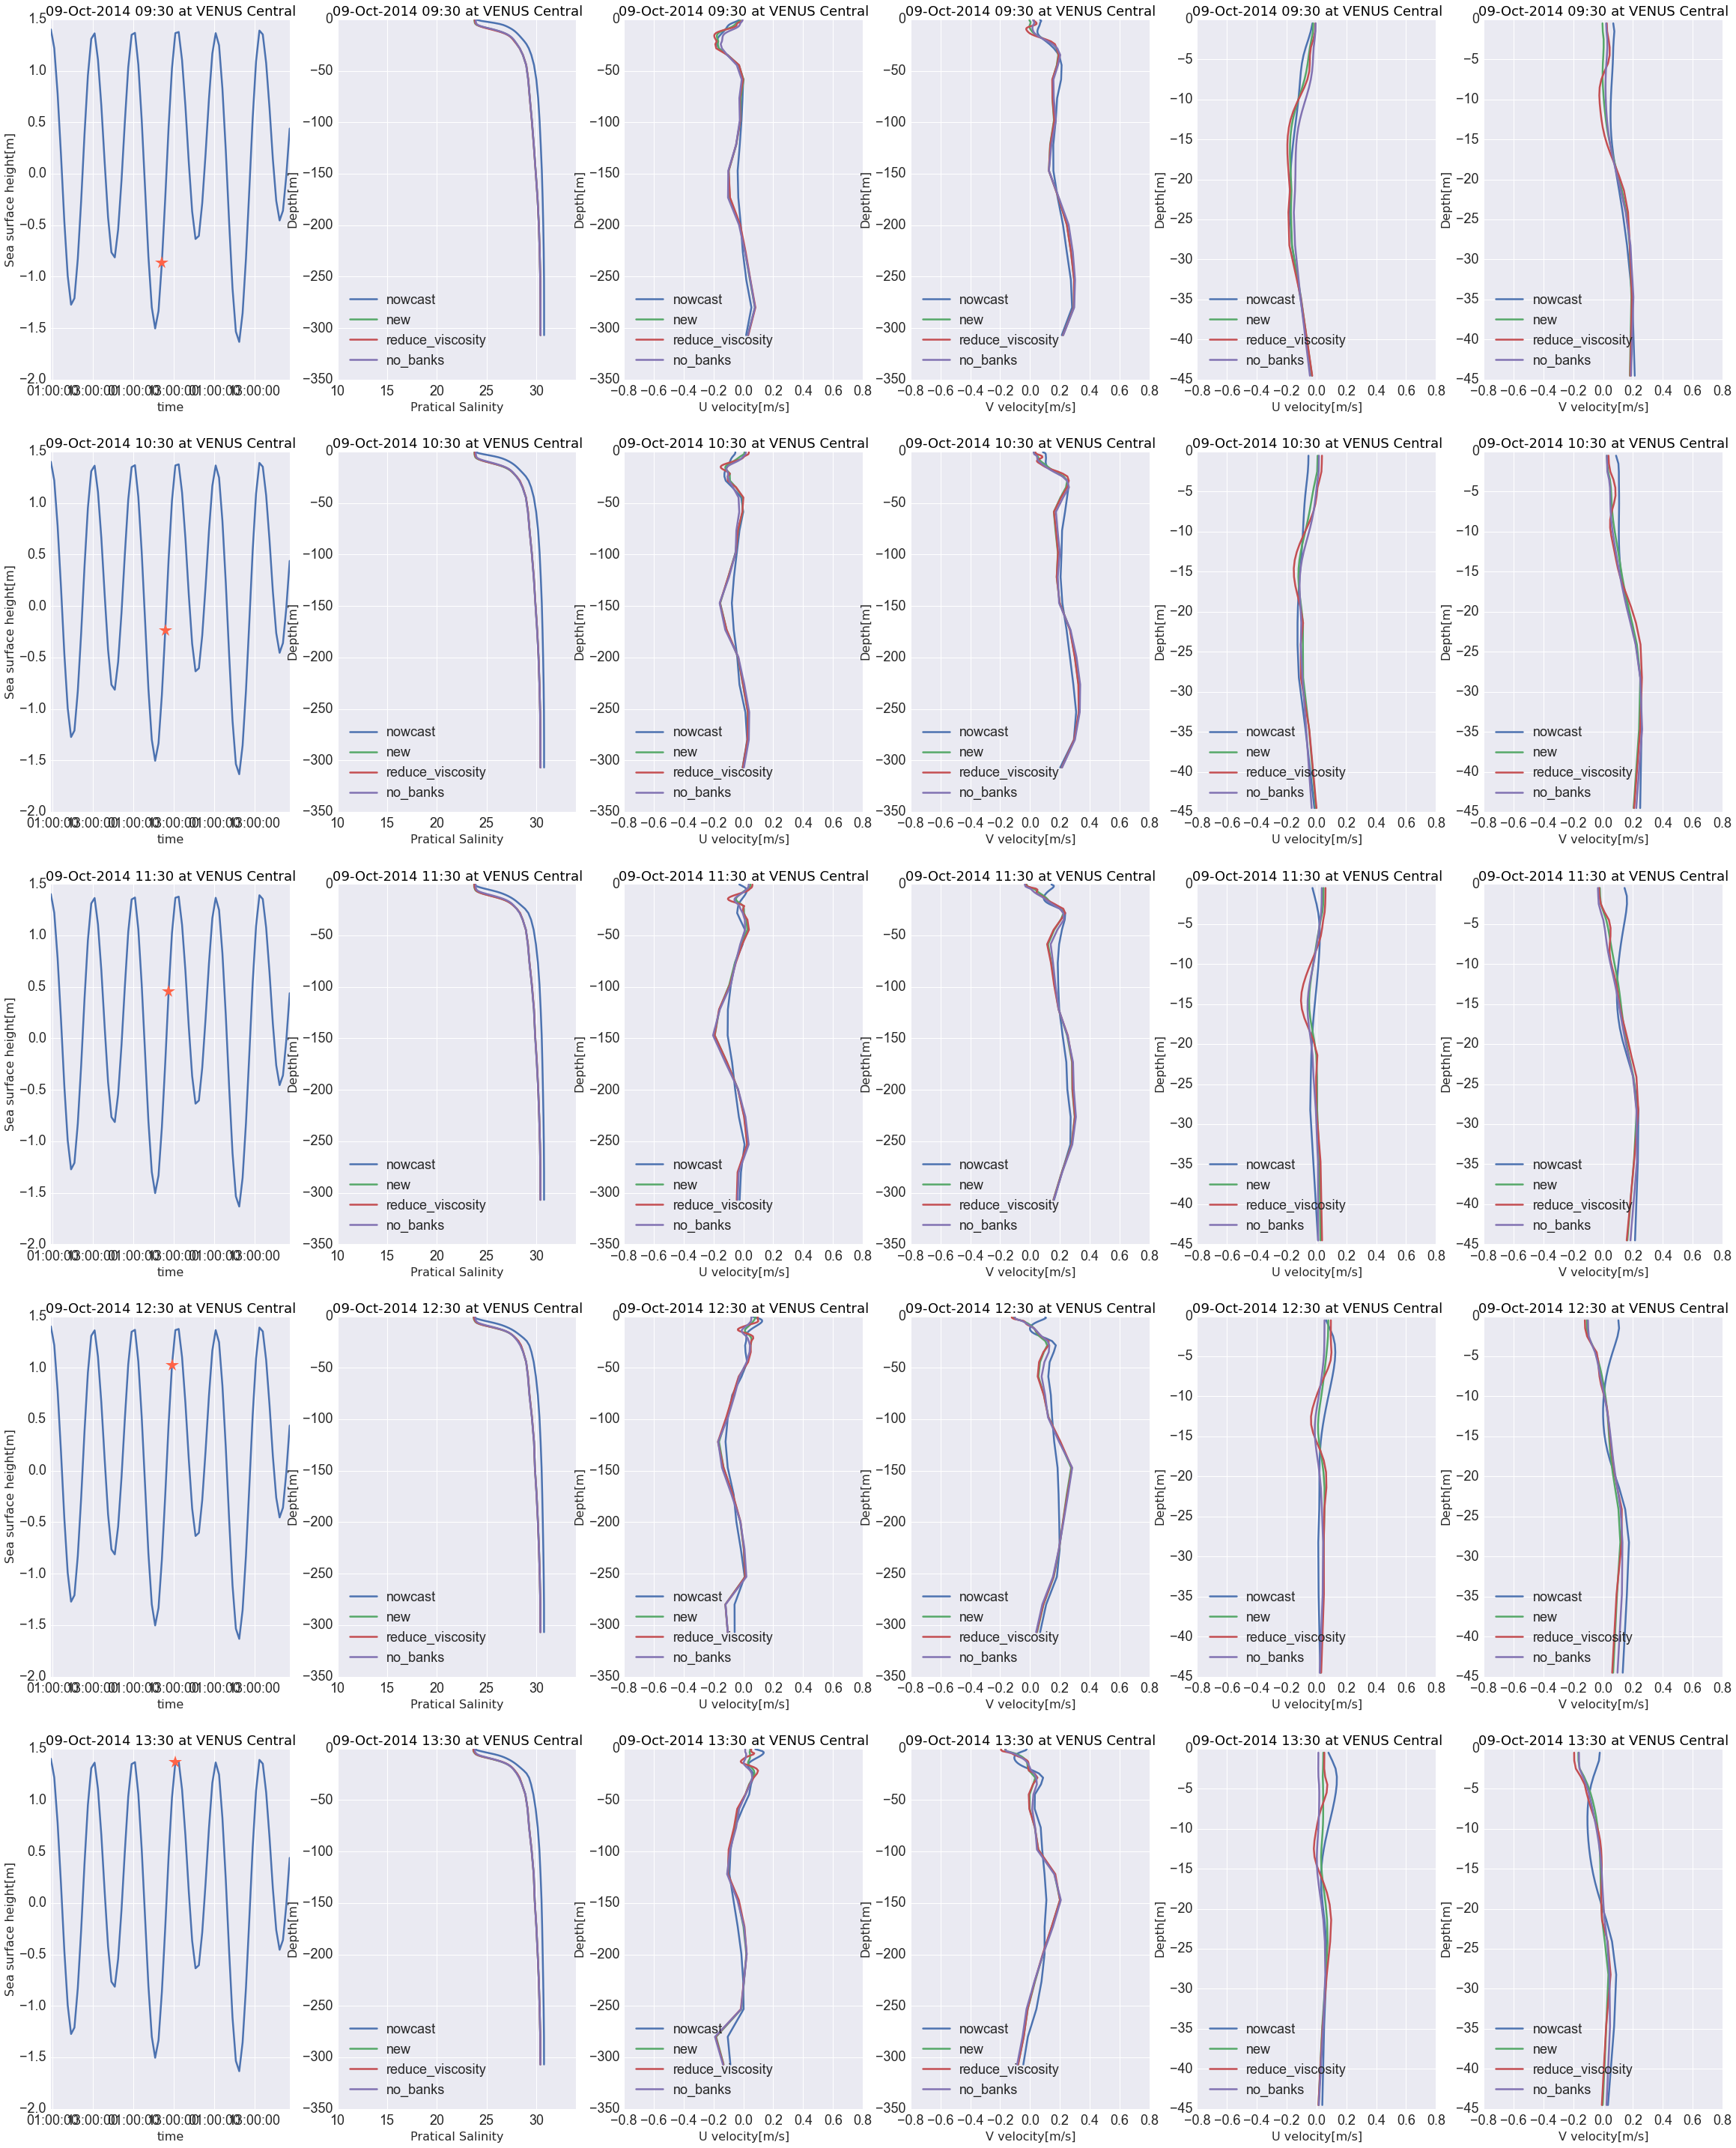

In [9]:
fig = plot_salinity_UV_SSH('VENUS Central', 33,5)

* VENUS East

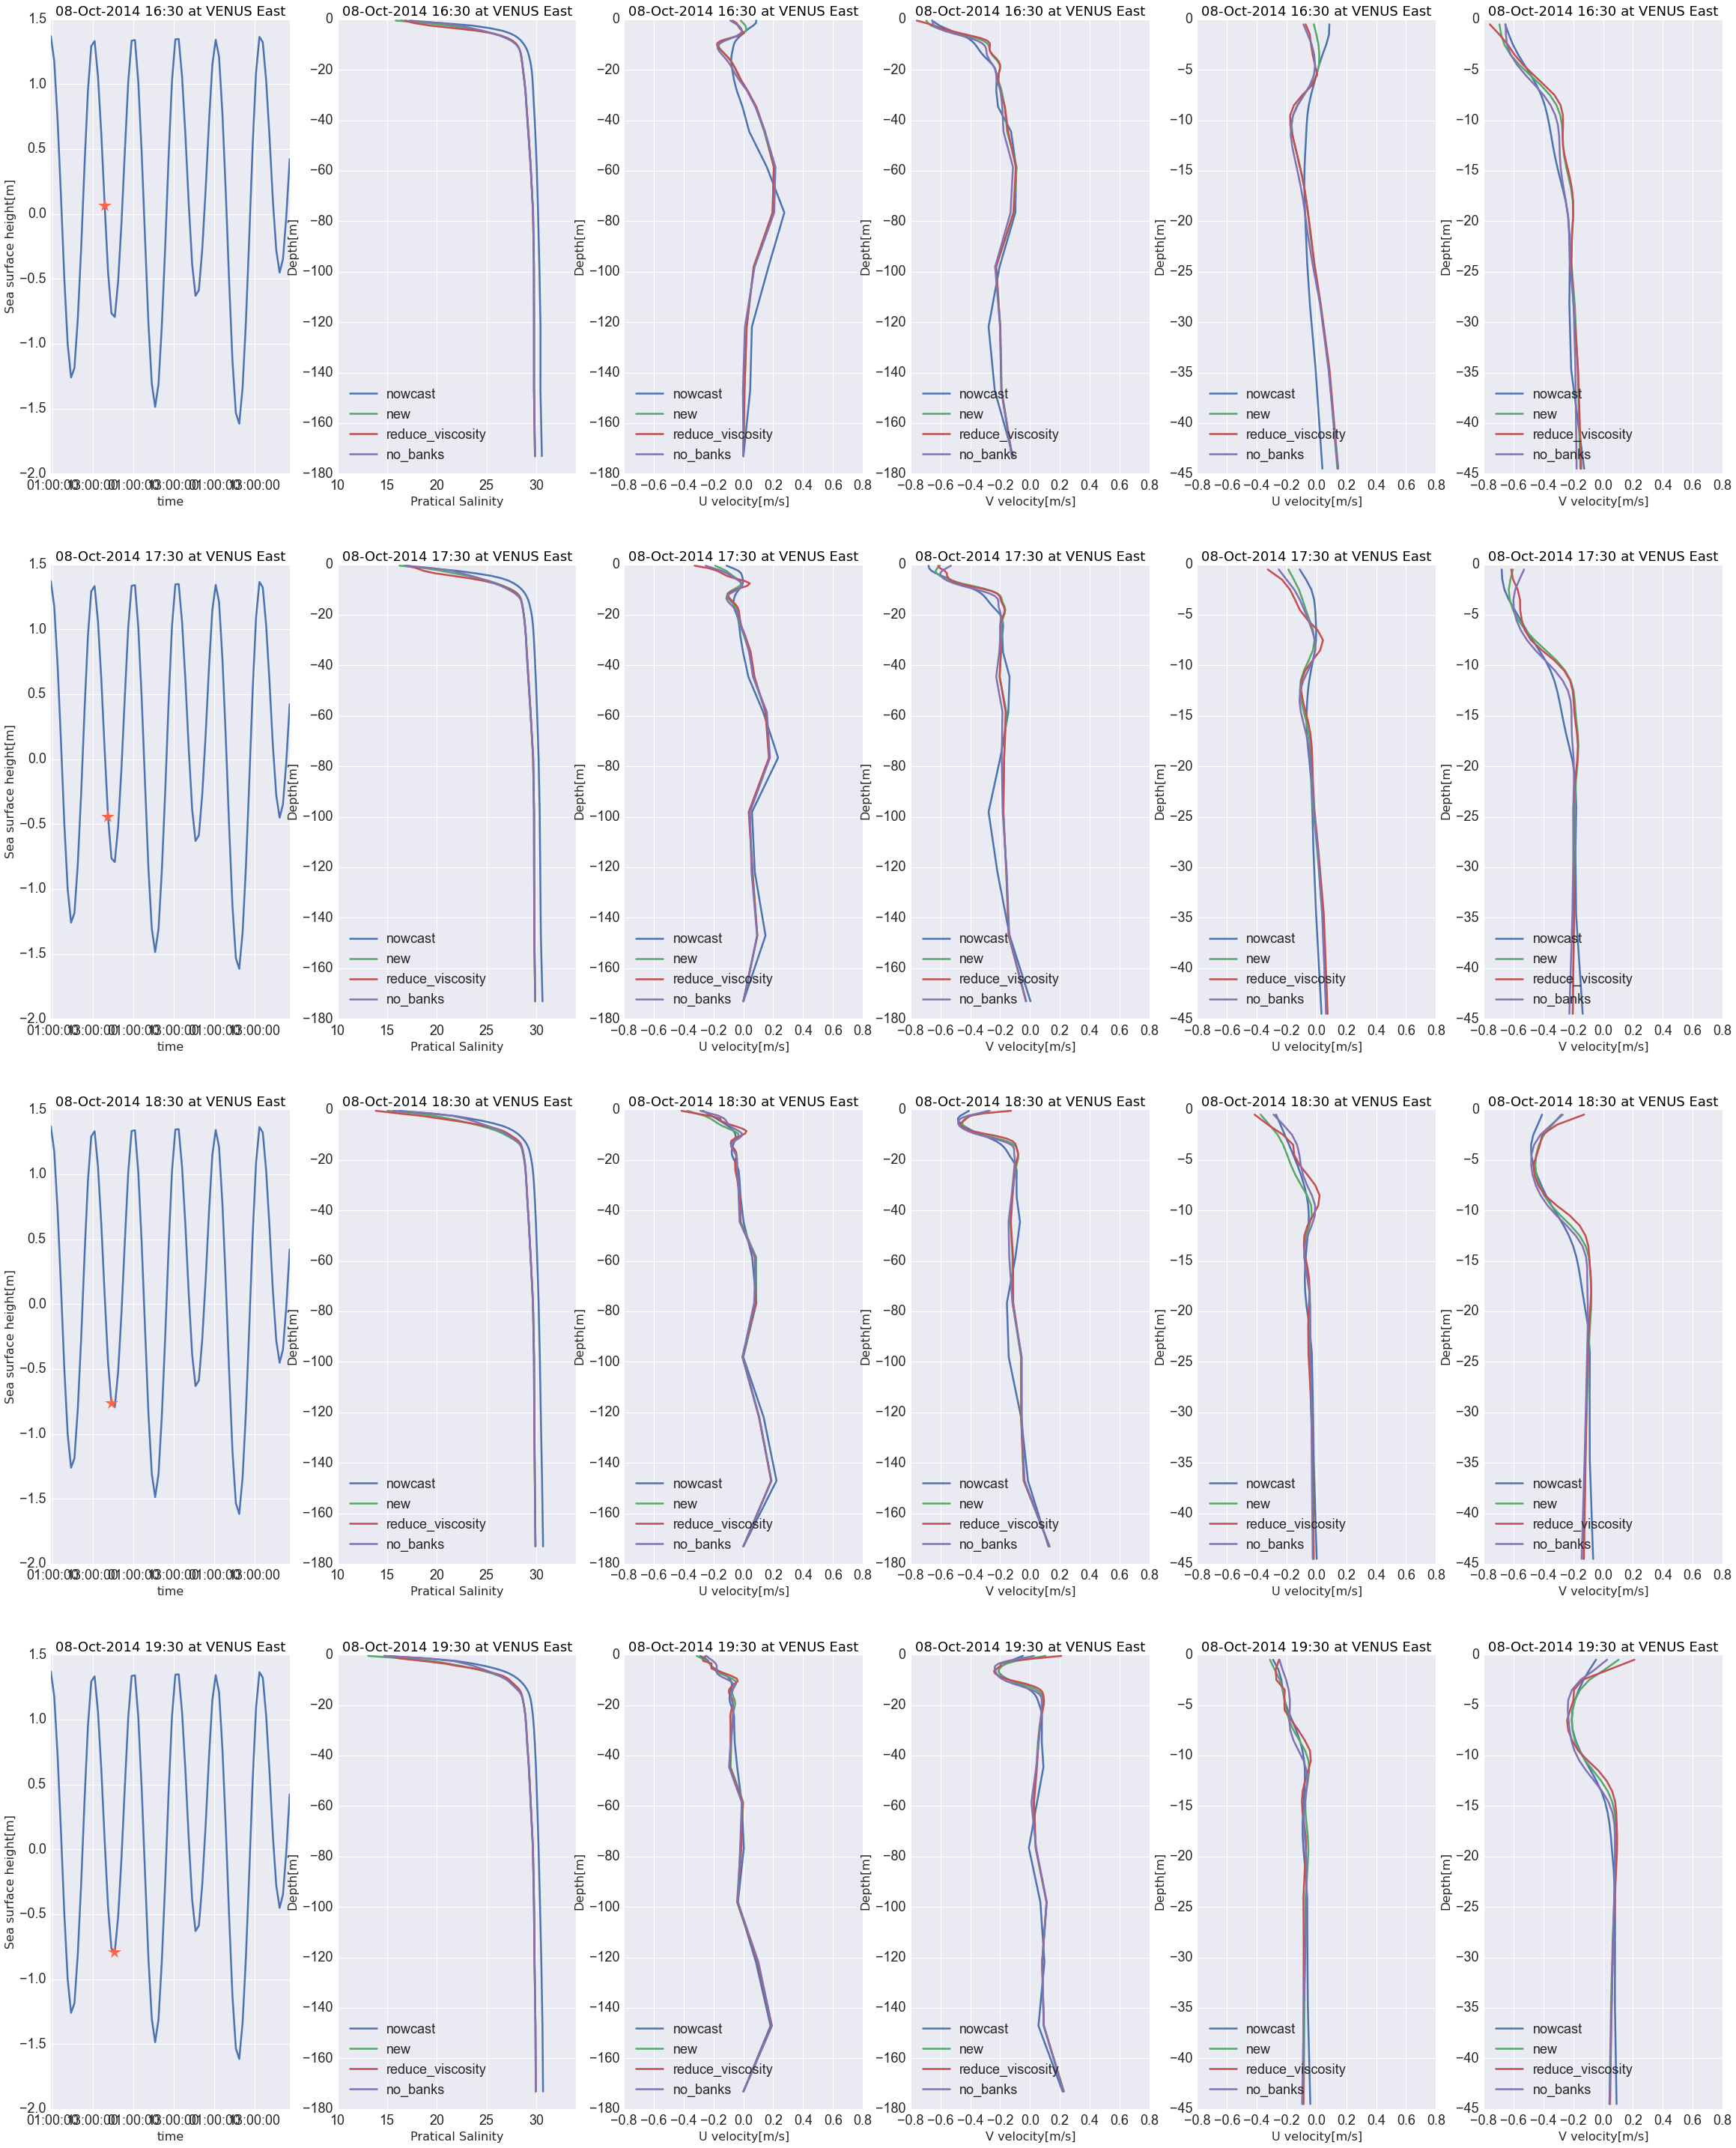

In [10]:
fig = plot_salinity_UV_SSH('VENUS East', 16,4)

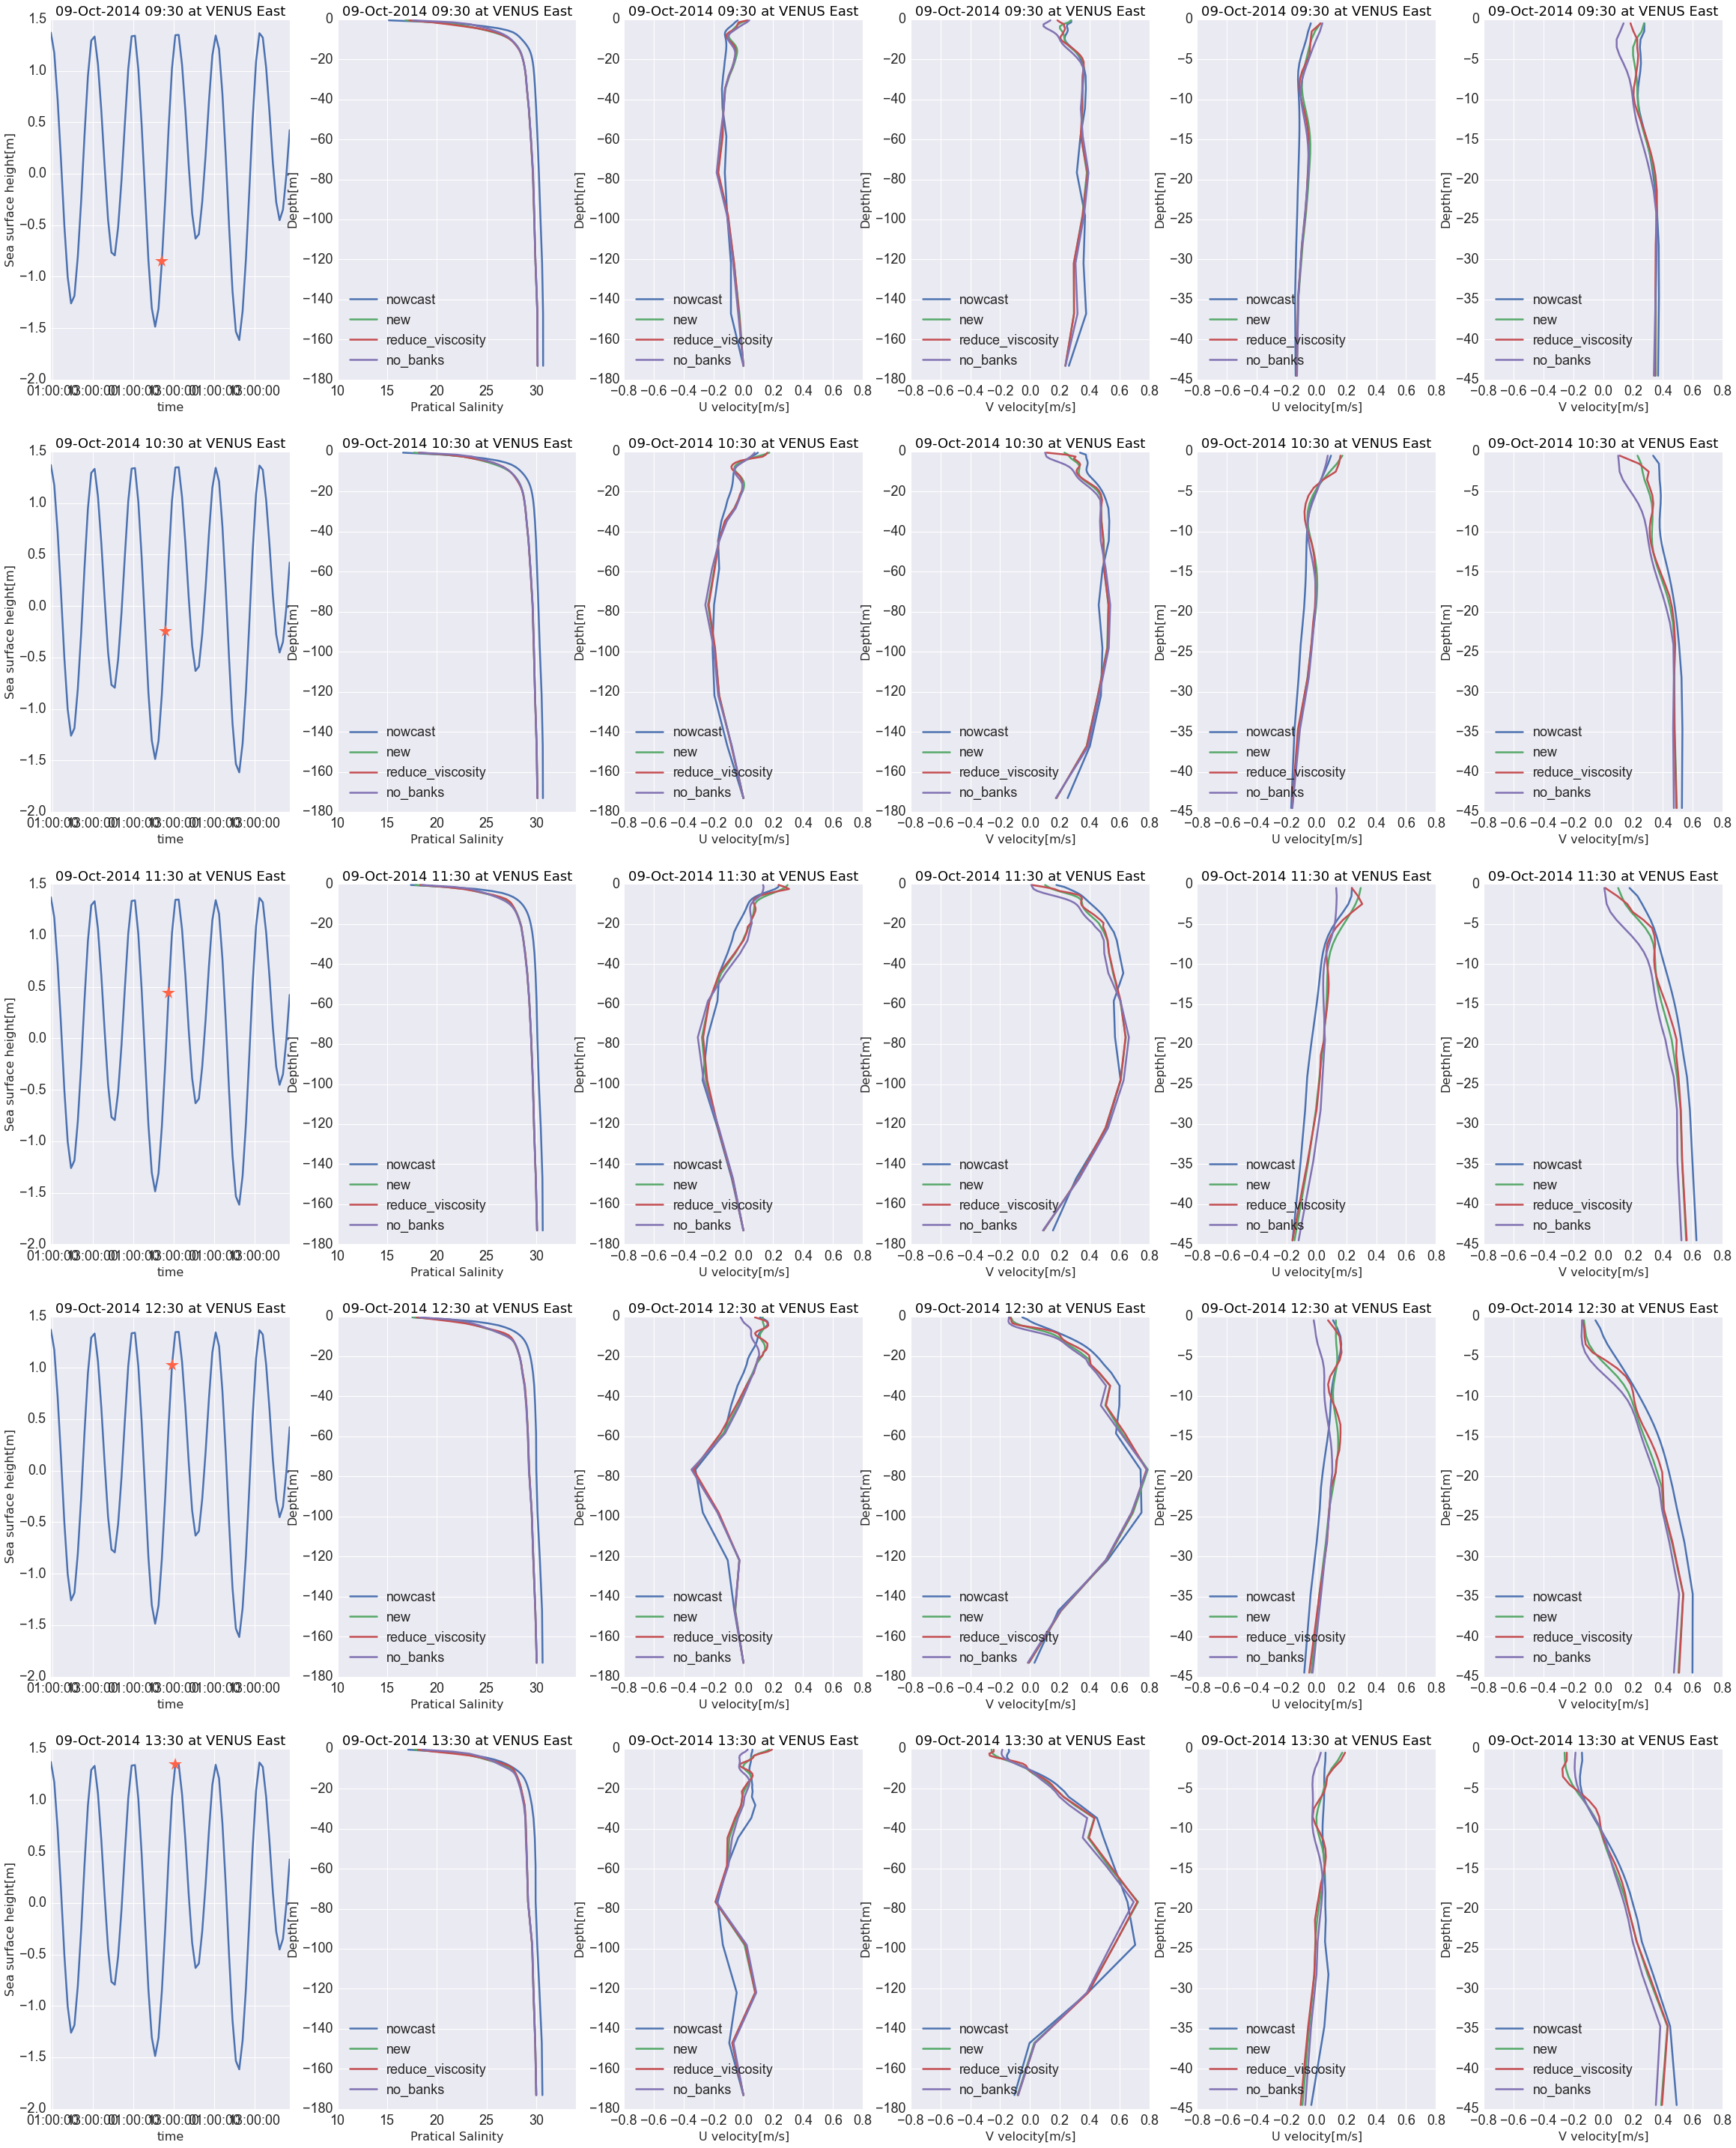

In [11]:
fig = plot_salinity_UV_SSH('VENUS East', 33,5)

* VENUS Delta

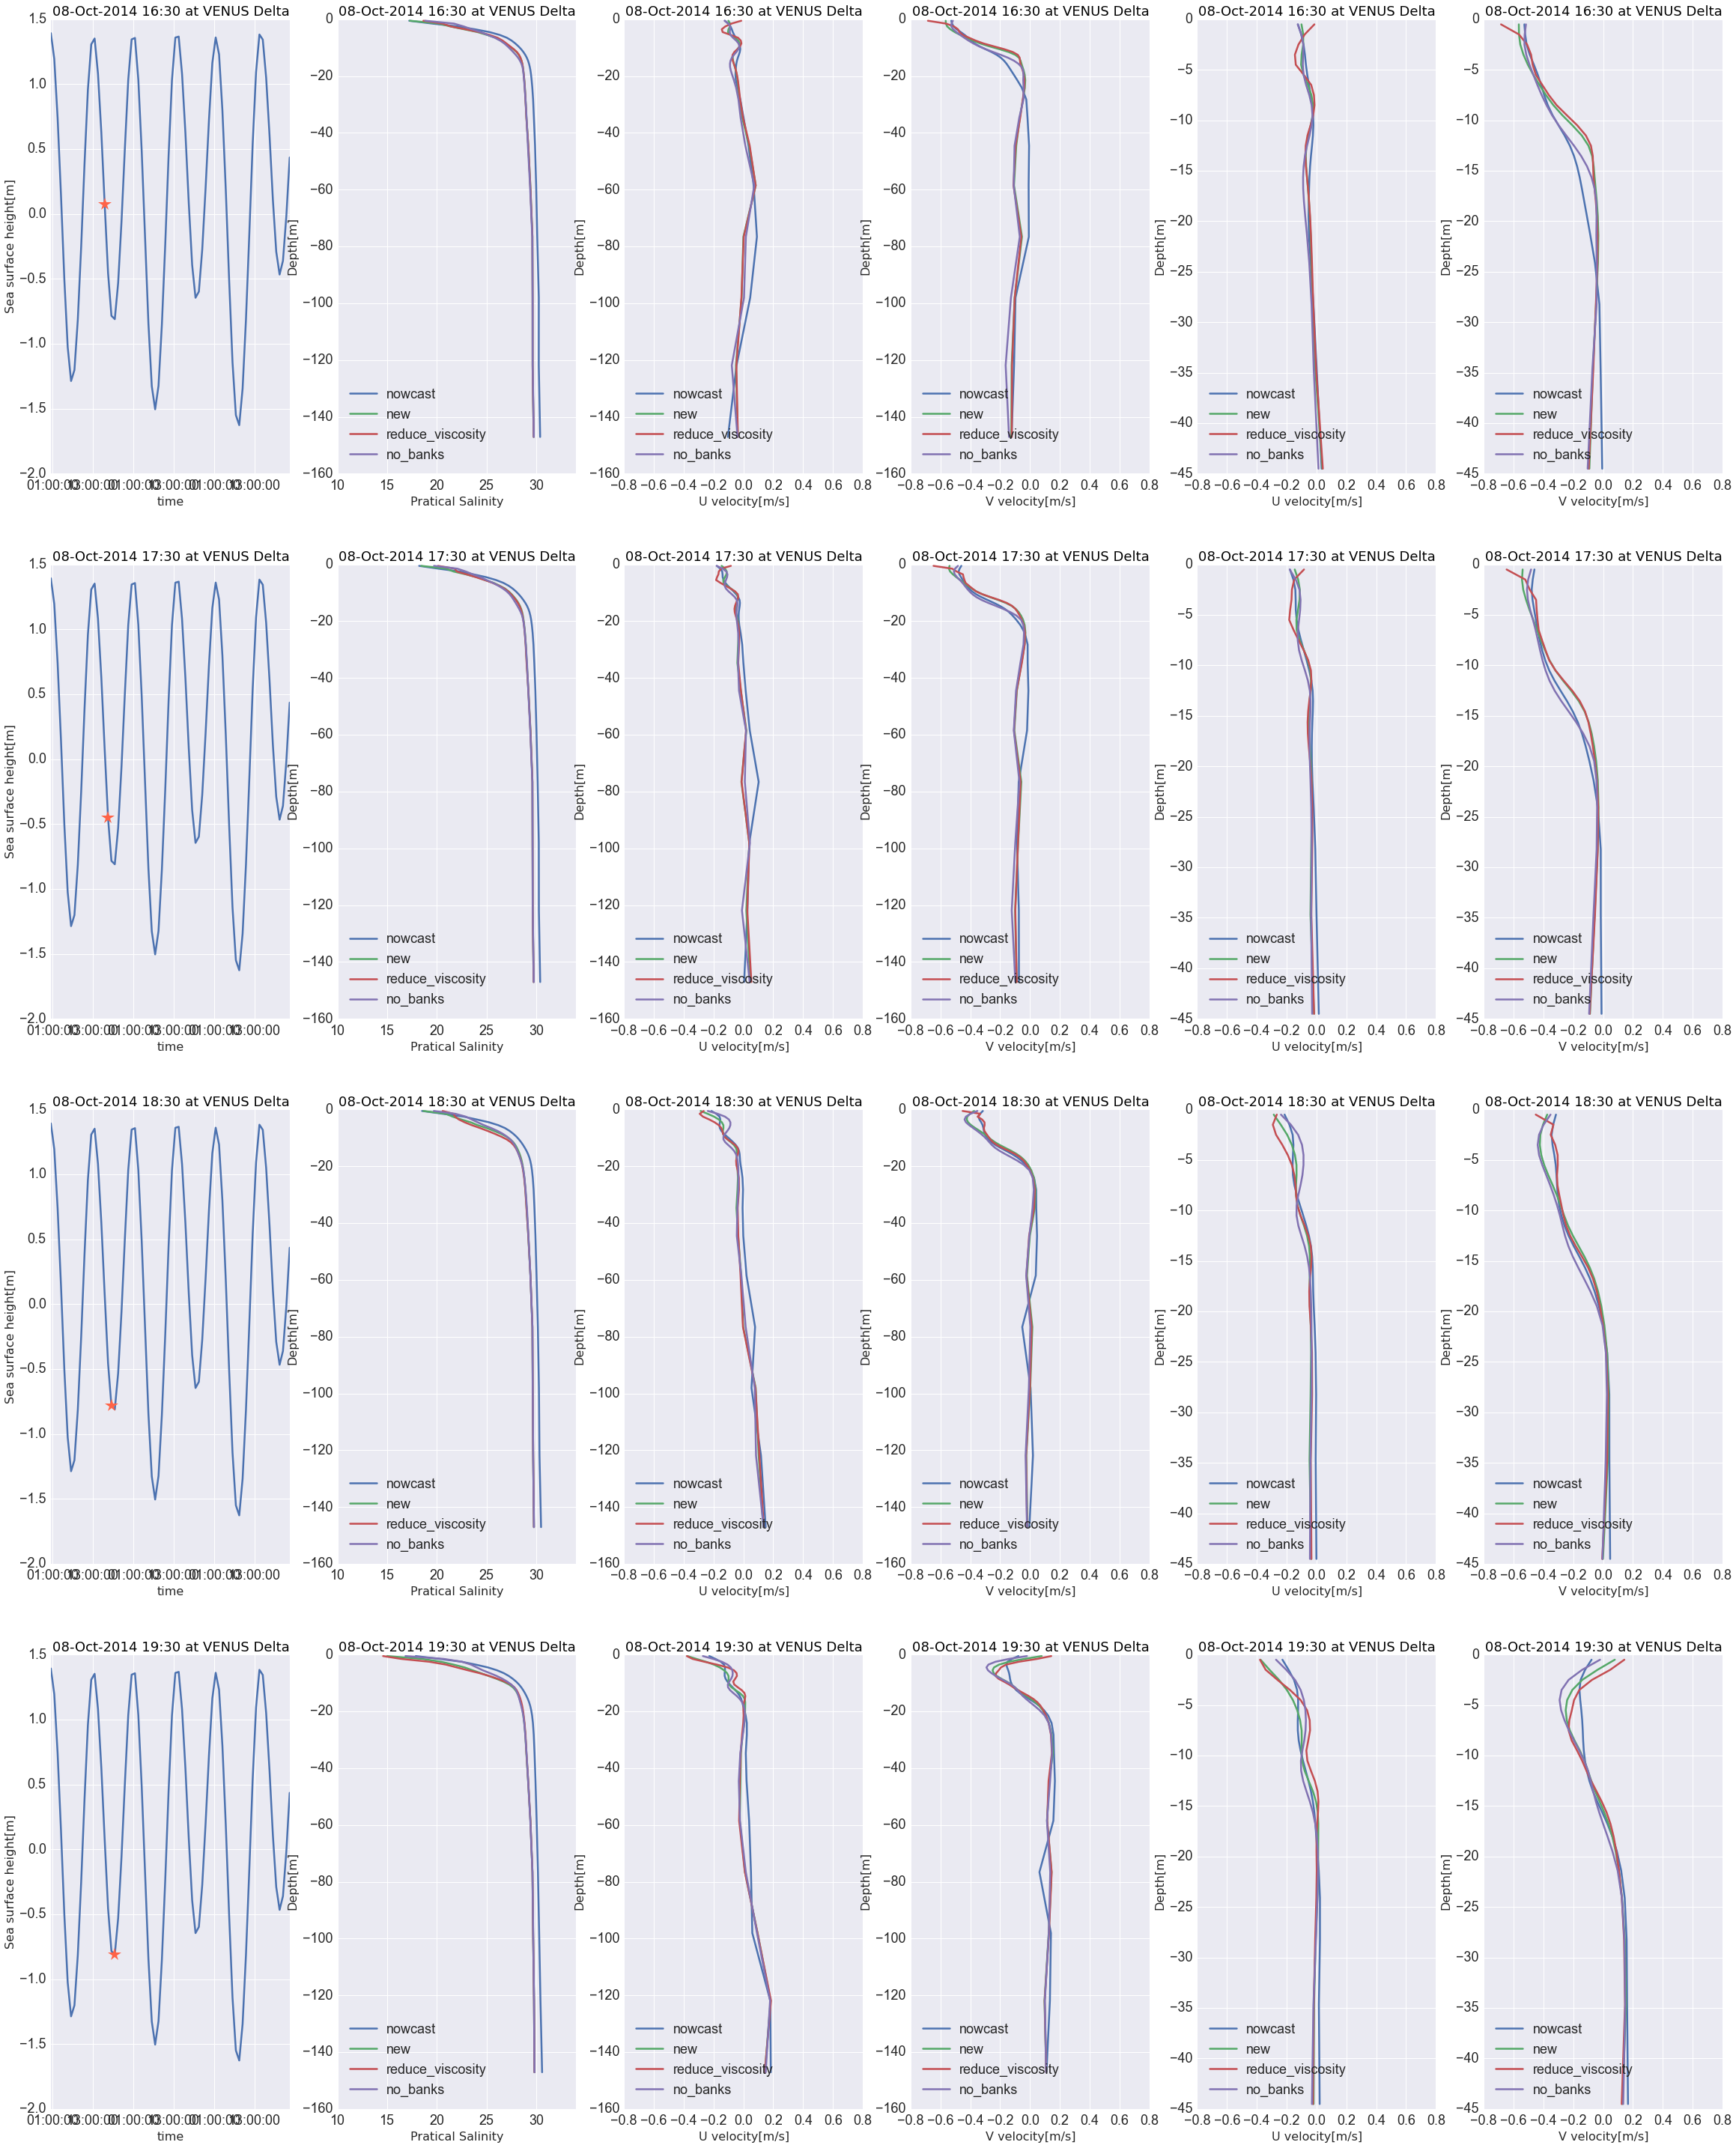

In [12]:
fig = plot_salinity_UV_SSH('VENUS Delta', 16,4)

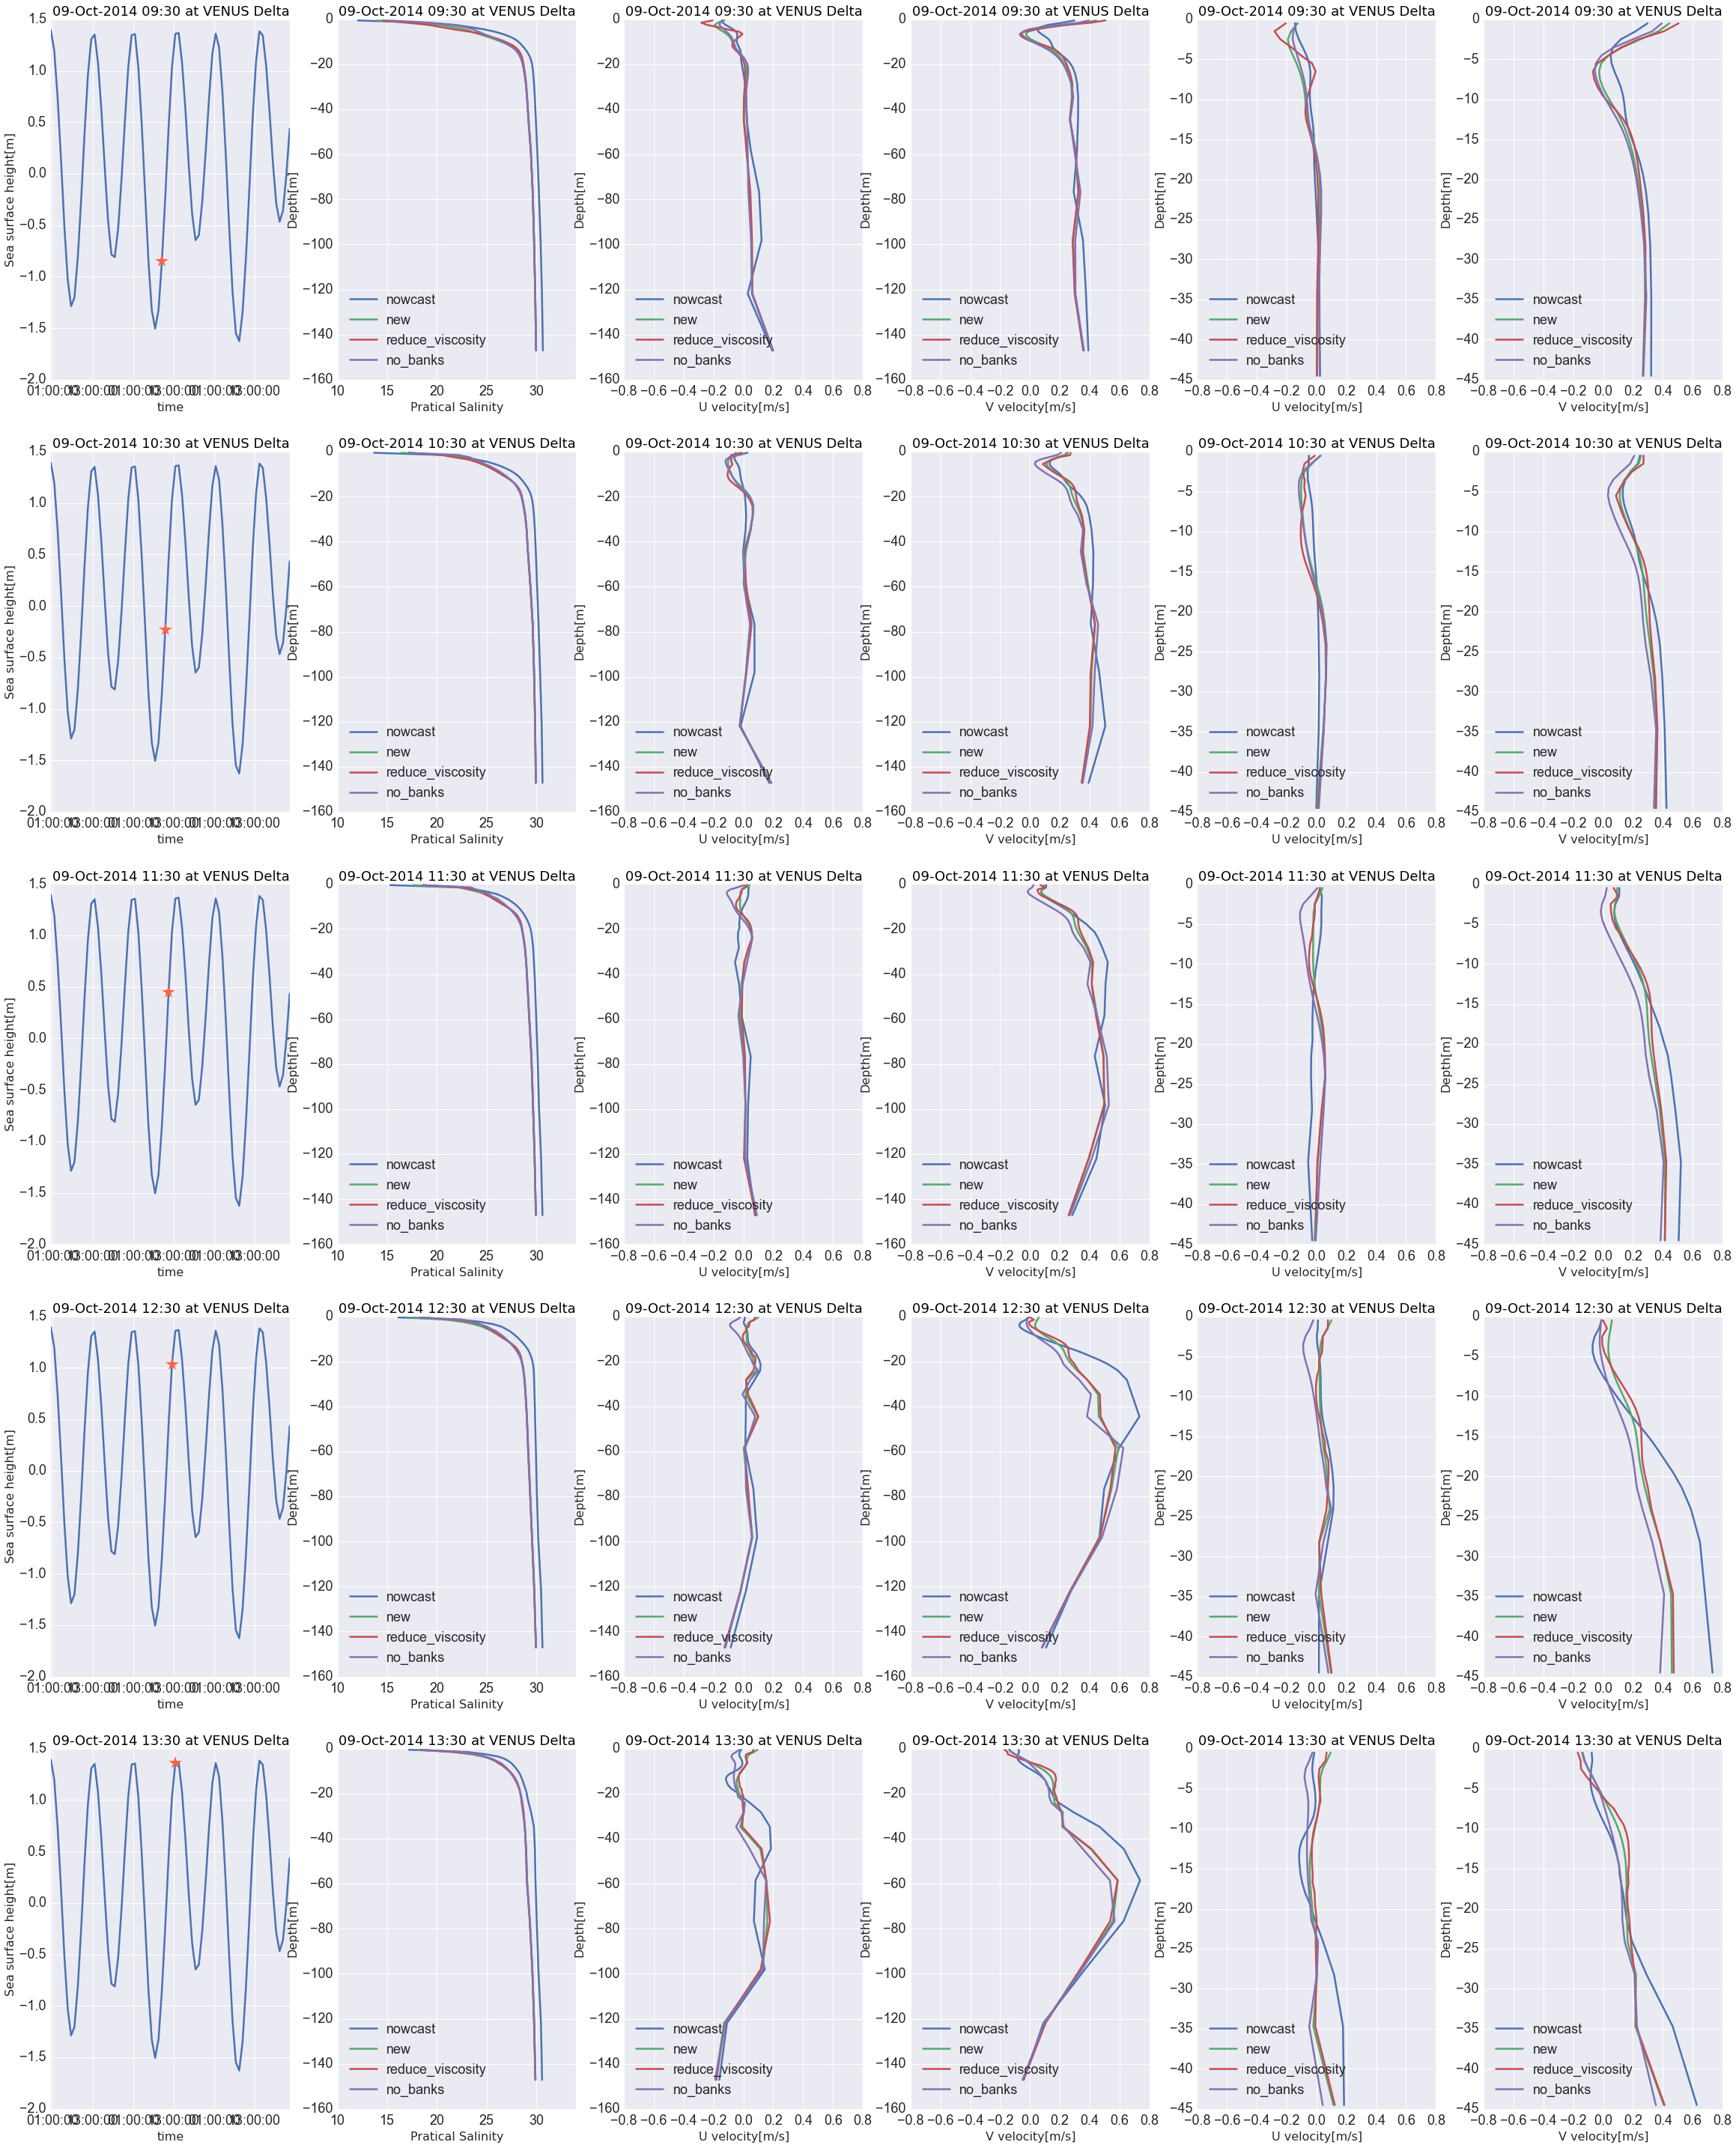

In [13]:
fig = plot_salinity_UV_SSH('VENUS Delta', 33,5)

* S4-3

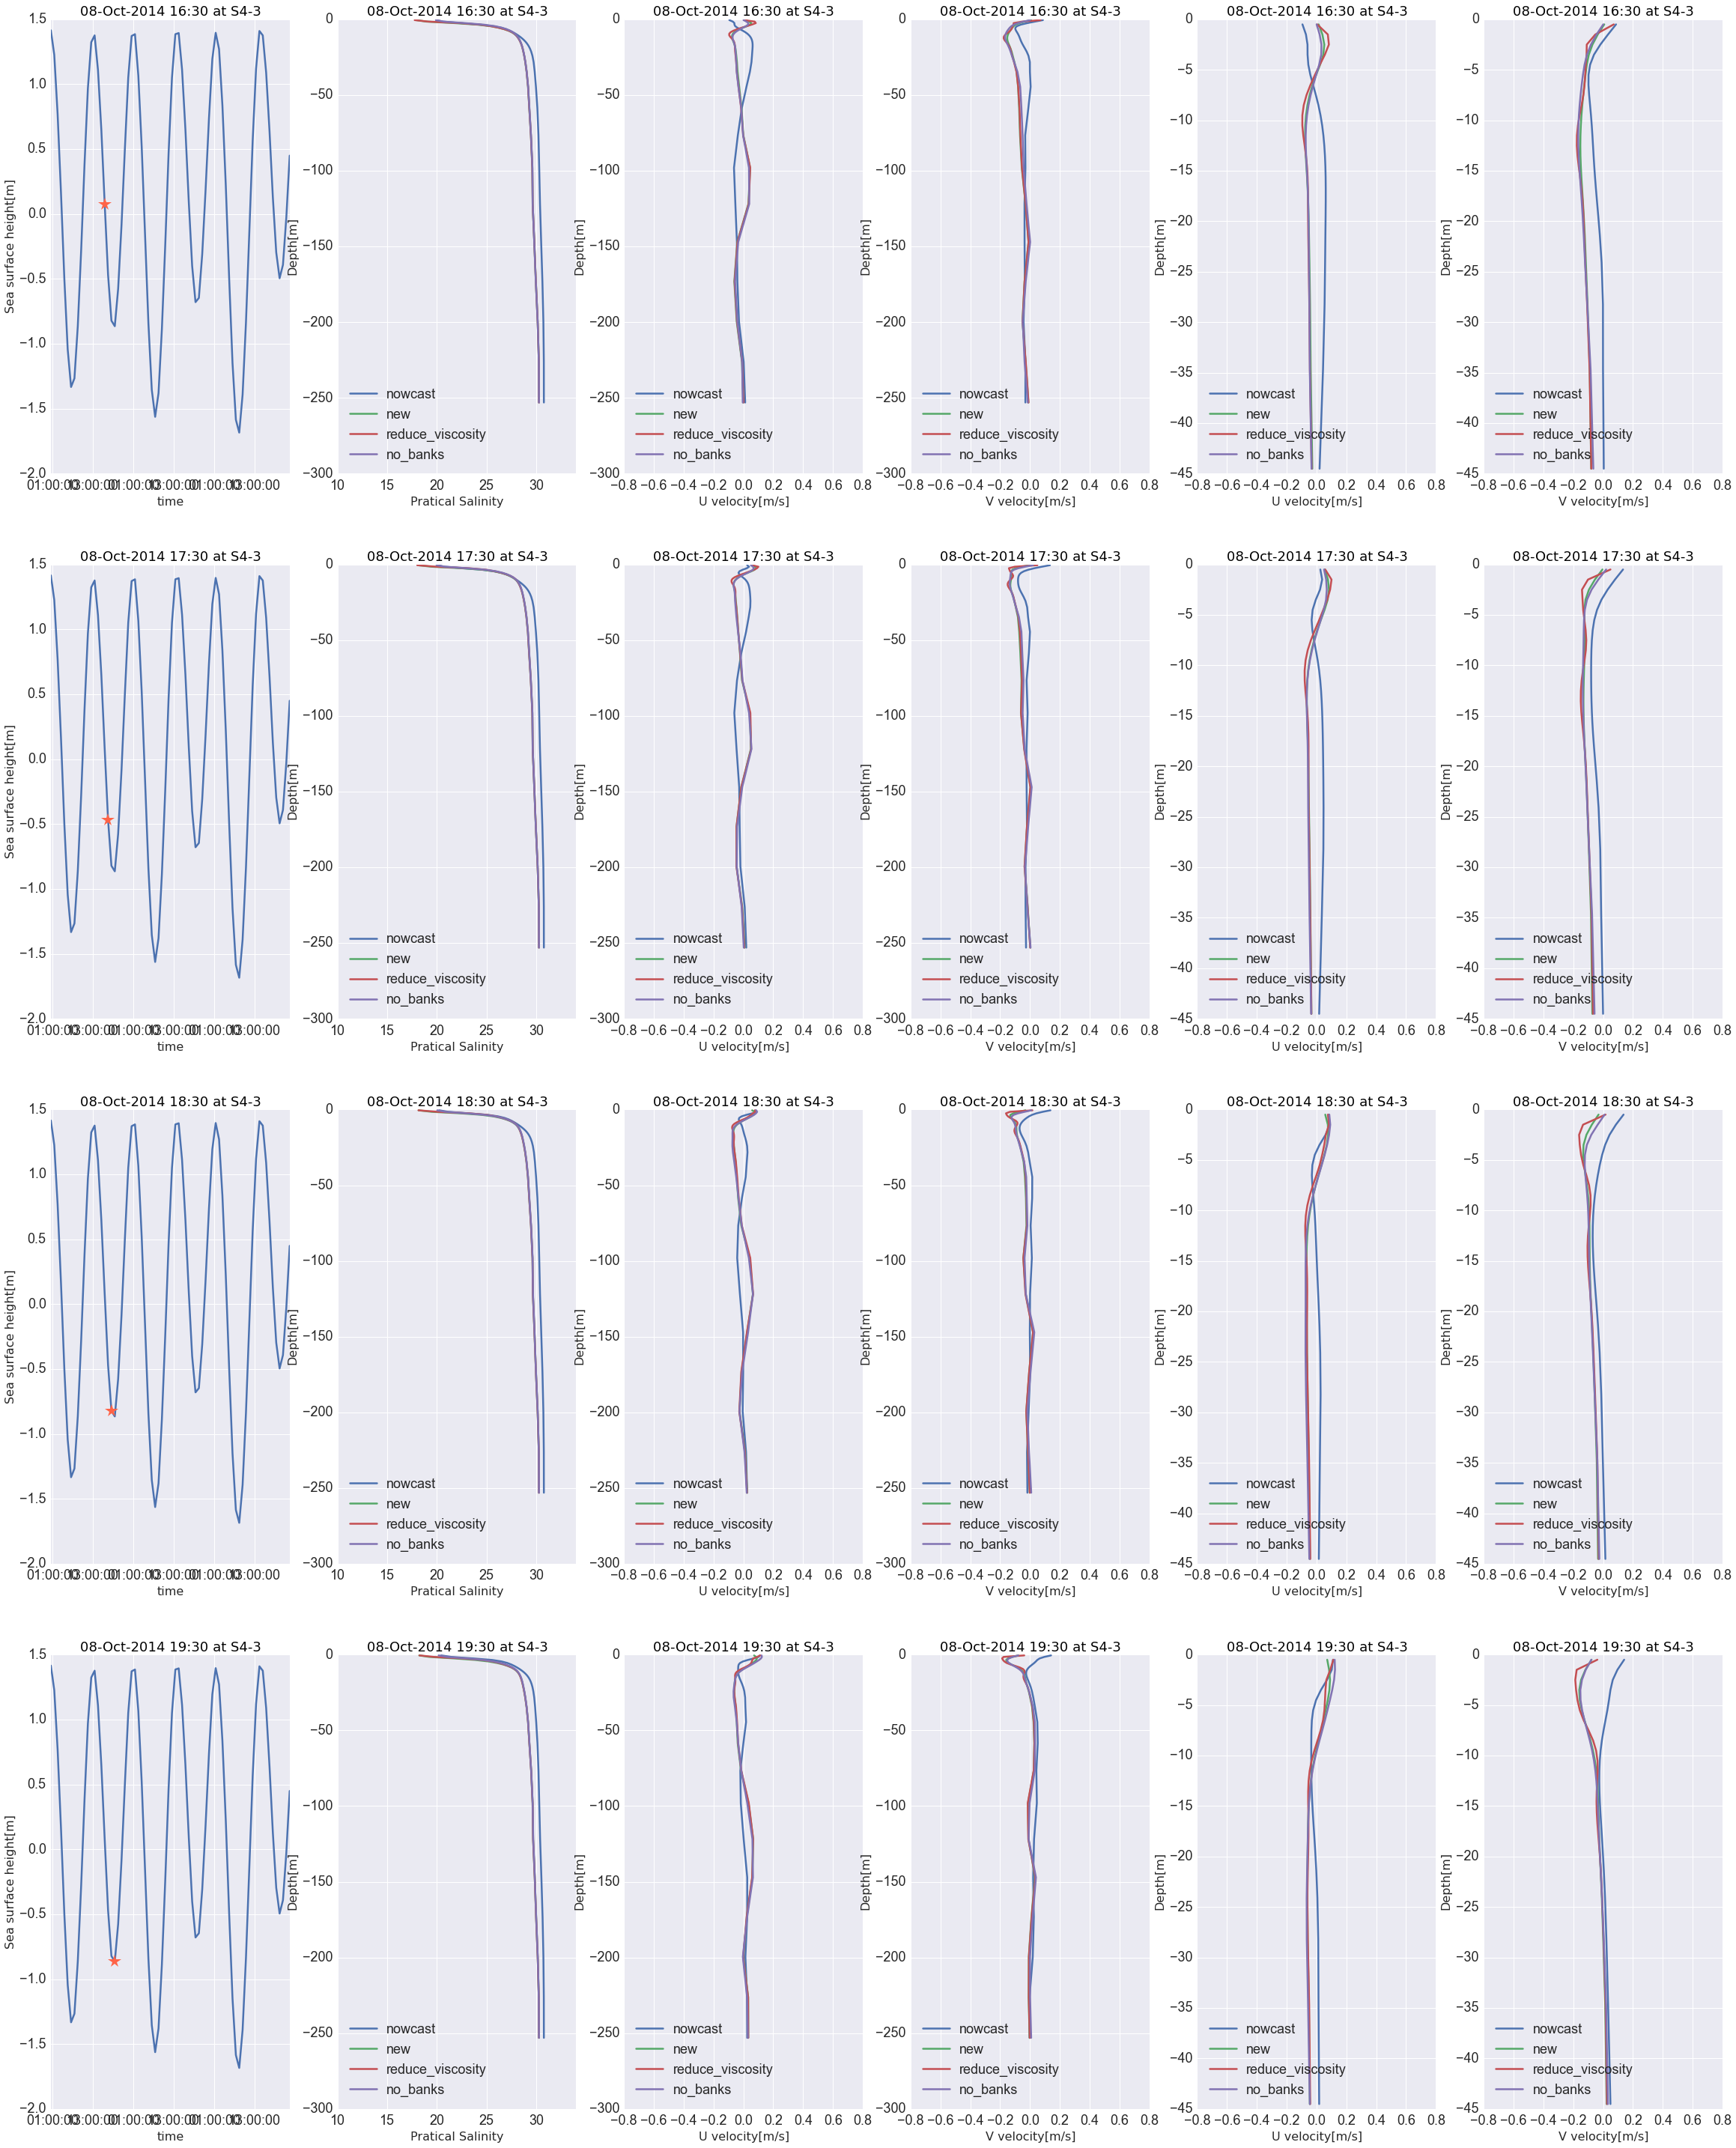

In [14]:
fig = plot_salinity_UV_SSH('S4-3', 16,4)

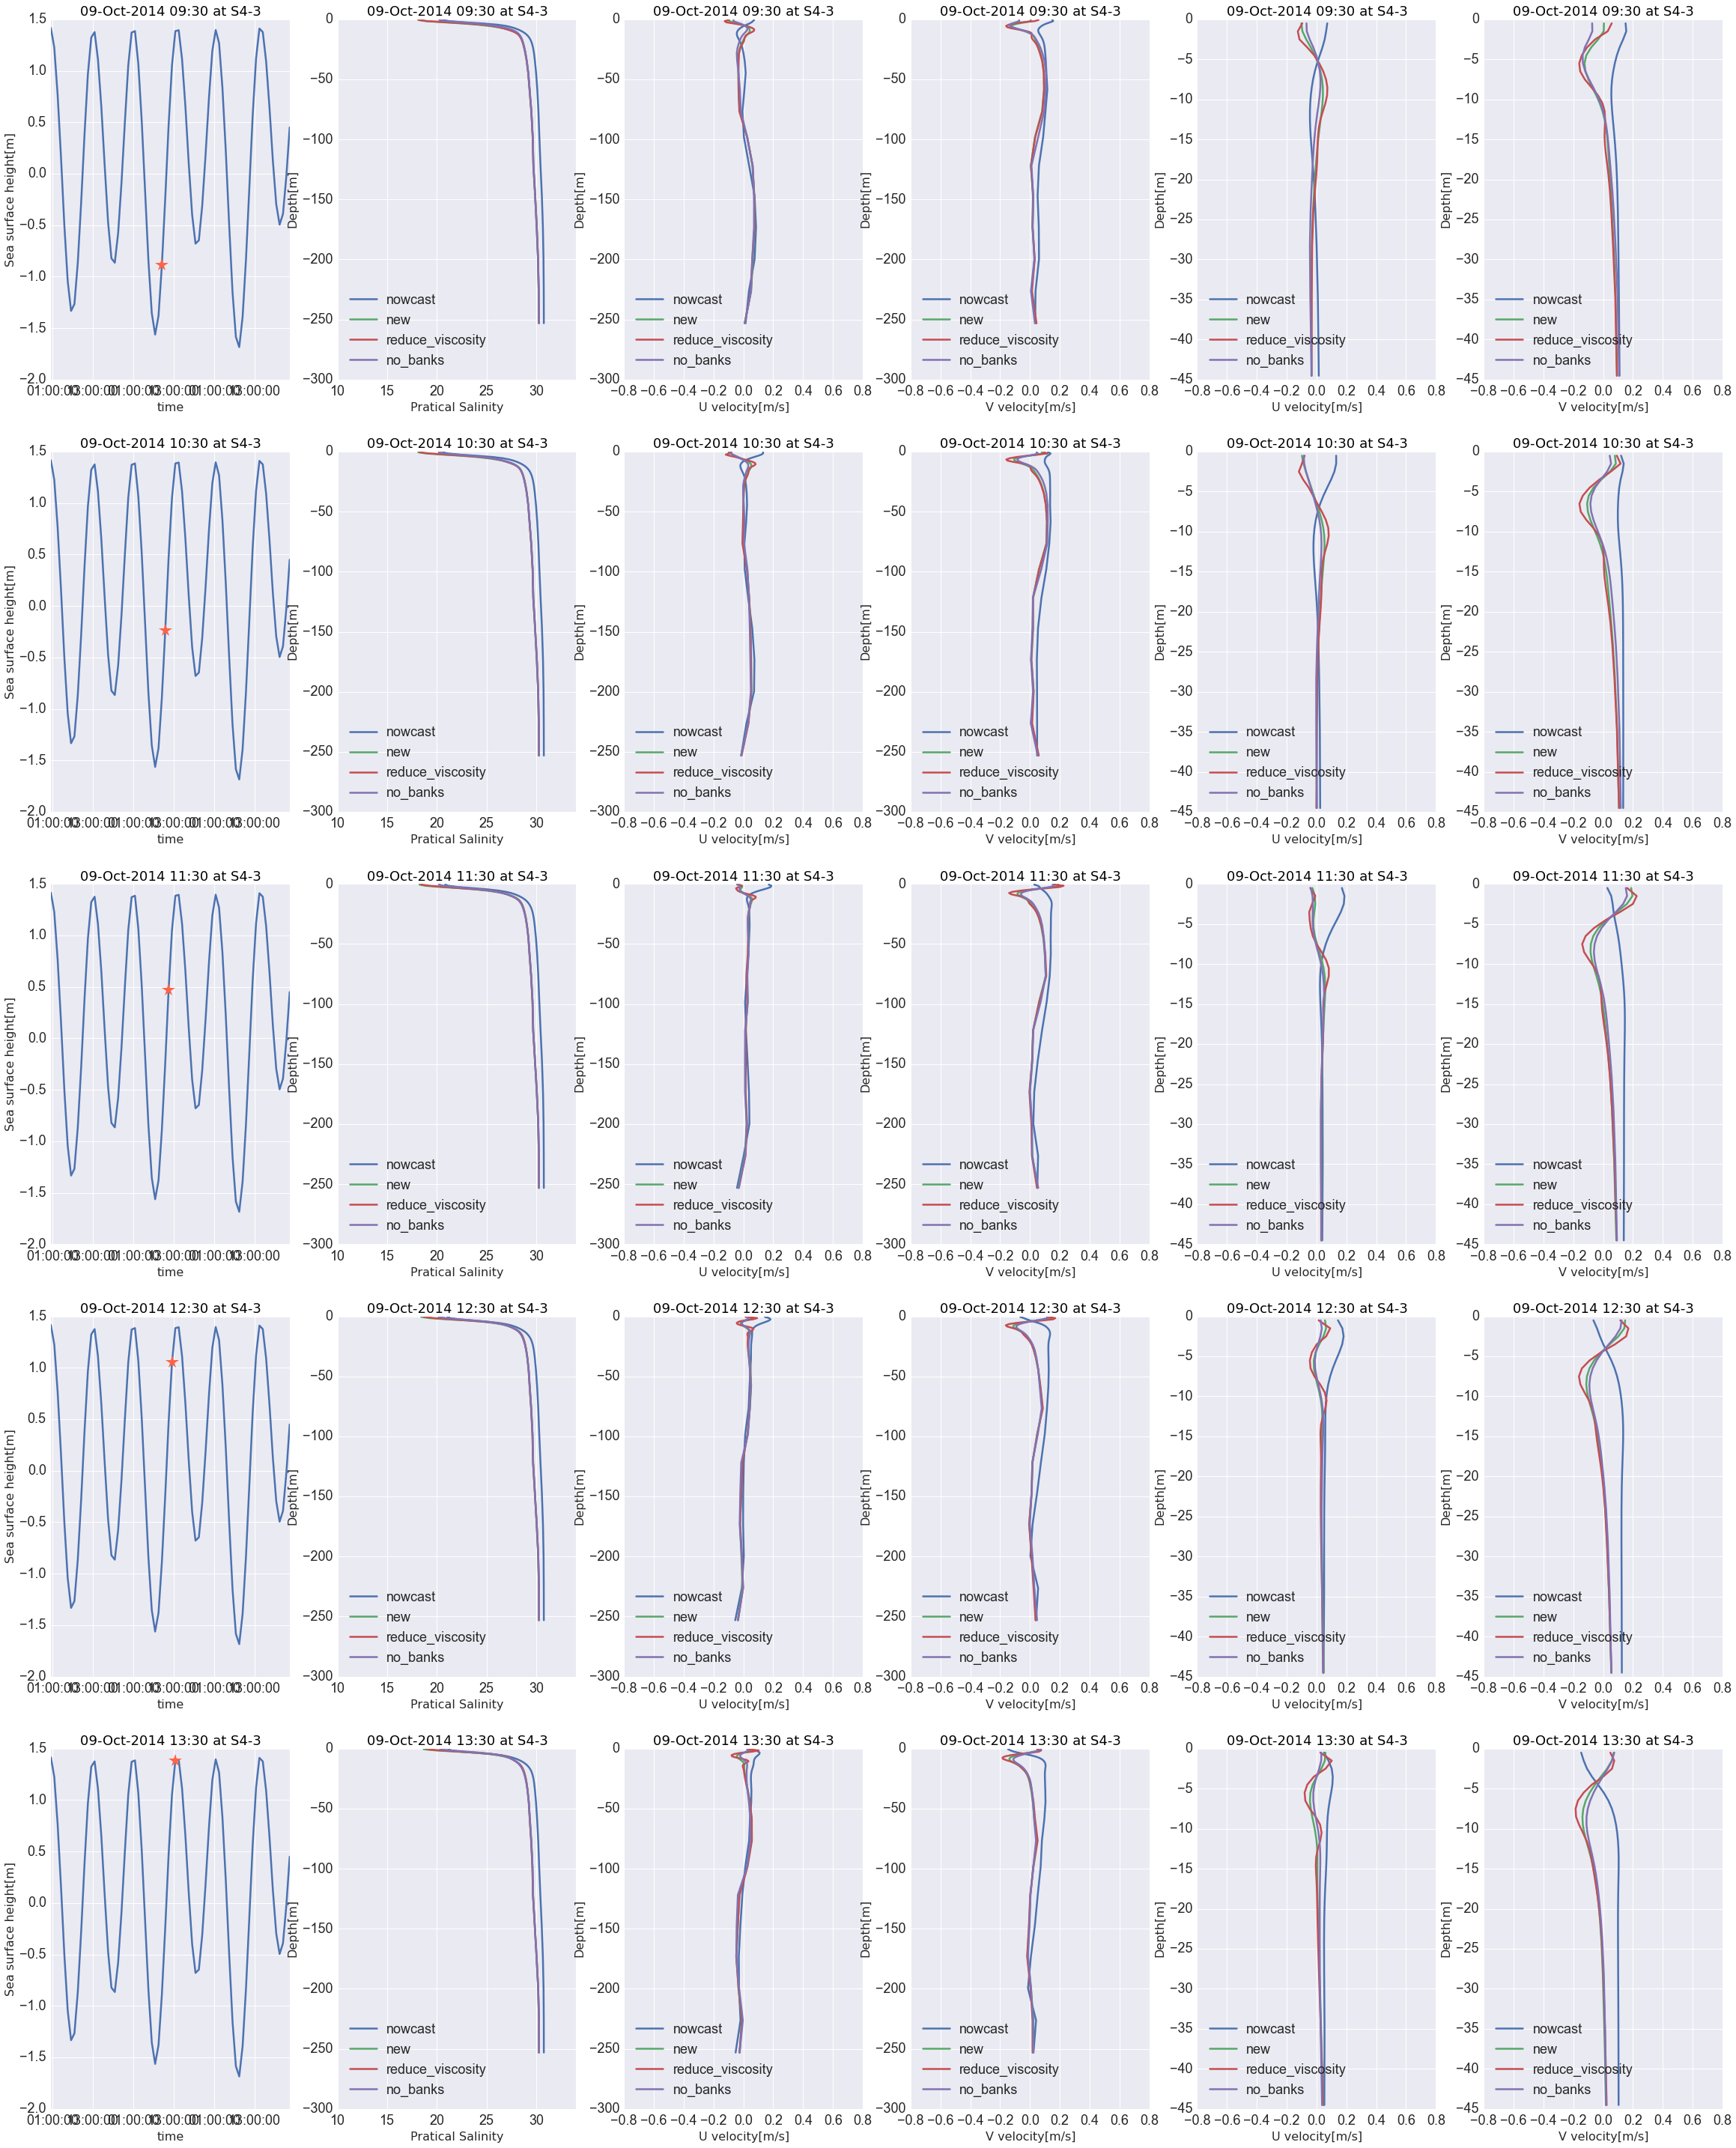

In [15]:
fig = plot_salinity_UV_SSH('S4-3', 33,5)